# Pseudo-bulk functional analysis

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform functional analyses at the pseudo-bulk level instead of the single-cell.
By doing so, we recover lowly expressed genes that before where affected by the "drop-out" effect of single-cell. 
Additionaly, if there is more than one condition in our data, we can perform differential expression analysis (DEA) and use the gene statistics as input for enrichment analysis.

In this notebook we showcase how to use `decoupler` for pathway and transcription factor (TF) enrichment from a human data-set. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results?plotType=umap&plotOption=20).

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [2]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Loading the data

We can download the data easily using `scanpy`:

In [22]:
import scanpy as sc
import pandas as pd
import os
adata = sc.read('/wynton/scratch/jding/brainchromatin/HM2D/D7-filtered_guides.IN.h5ad')
adata.obs['Gene_target'] = adata.obs['gene_NKS'] 
targets = [x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
targets.append('non-targeting')
adata = adata[adata.obs['Gene_target'].isin(targets)]
adata.obs['predictions'] = adata.obs['subtype']
adata.obs['perturbation'] = ['Perturbed' if x in ['IN_LMO1/RIC3','IN_CALB2/SPOCK1'] else 'WT' for x in adata.obs['predictions']]

/scratch/jding/ipykernel_2644096/1239882985.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['predictions'] = adata.obs['subtype']


In [89]:
import scanpy as sc
import pandas as pd
import os
adata = sc.read('/wynton/scratch/jding/brainchromatin/Li/HM2D_IN_query.h5ad')
adata.obs['Gene_target'] = adata.obs['gene_NKS'] 
targets = [x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
targets.append('non-targeting')
adata = adata[adata.obs['Gene_target'].isin(targets)]
adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]
adata.obs['stage'] = [x.split('#')[0] for x in adata.obs['individual']]
adata.obs['perturbation'] = ['Perturbed' if x in ['IN_LMO1/RIC3','IN_CALB2/SPOCK1'] else 'WT' for x in adata.obs['predictions']]

adata = adata[adata.obs['species'] == 'human']

/scratch/jding/ipykernel_2644096/424671685.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]


In [4]:
adata.obs['predictions'].unique()

['IN_LMO1/RIC3', 'IN_CALB2/SPOCK1', 'IN_PBX3/GRIA1', 'IN_PAX6/ST18', 'IN_NFIA/ST18', 'IN_CALB2/FBN2']
Categories (6, object): ['IN_CALB2/FBN2', 'IN_CALB2/SPOCK1', 'IN_LMO1/RIC3', 'IN_NFIA/ST18', 'IN_PAX6/ST18', 'IN_PBX3/GRIA1']

## Processing

This specific data-set contains ensmbl gene ids instead of gene symbols. 
To be able to use `decoupler` we need to transform them into gene symbols:

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

In [90]:
# Store raw counts in layers
#adata.X = np.round(adata.X)
adata.raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

We can also look how cells cluster by cell identity:

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


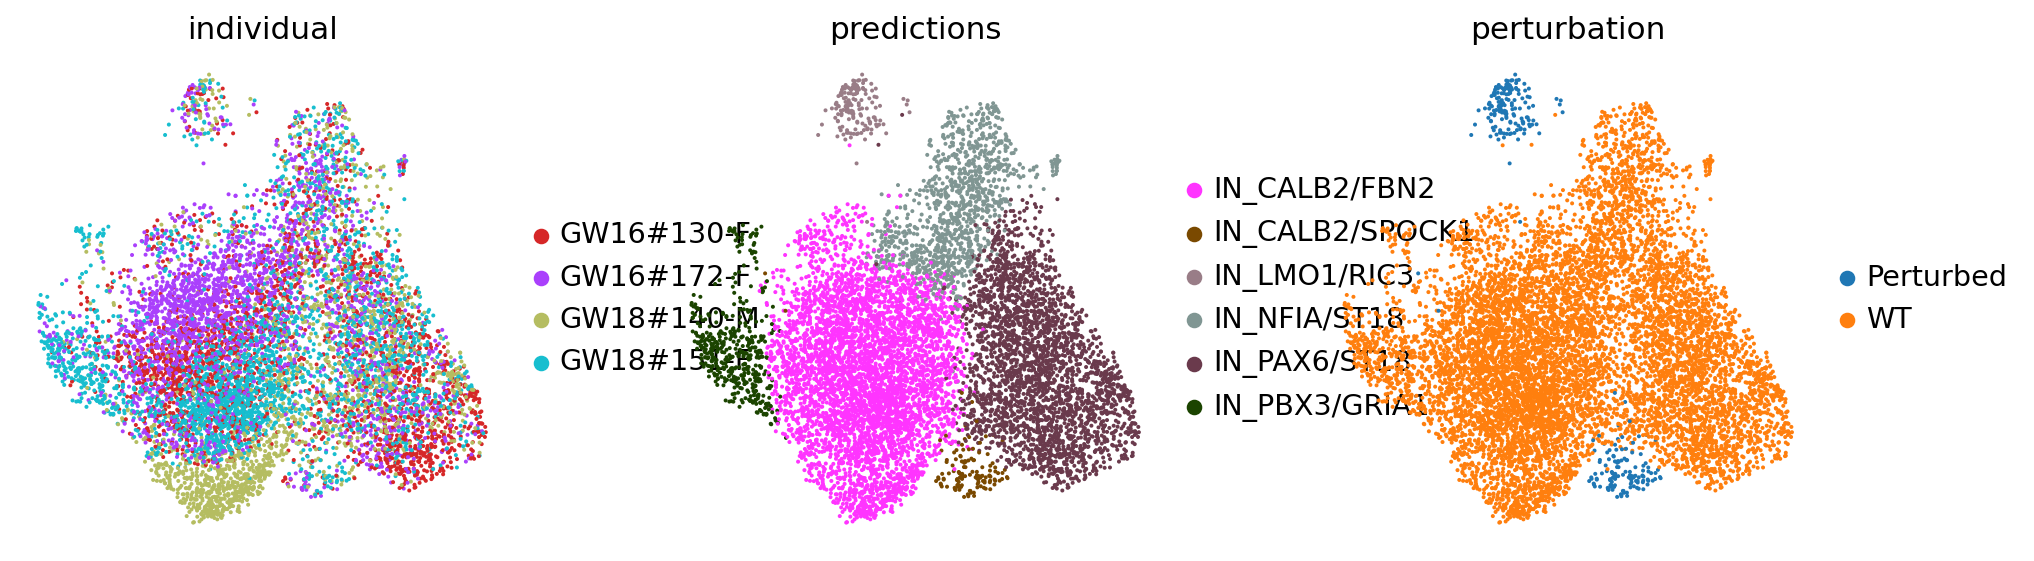

In [24]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual',min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Visualize
sc.pl.umap(adata, color=['individual','predictions','perturbation'], frameon=False)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


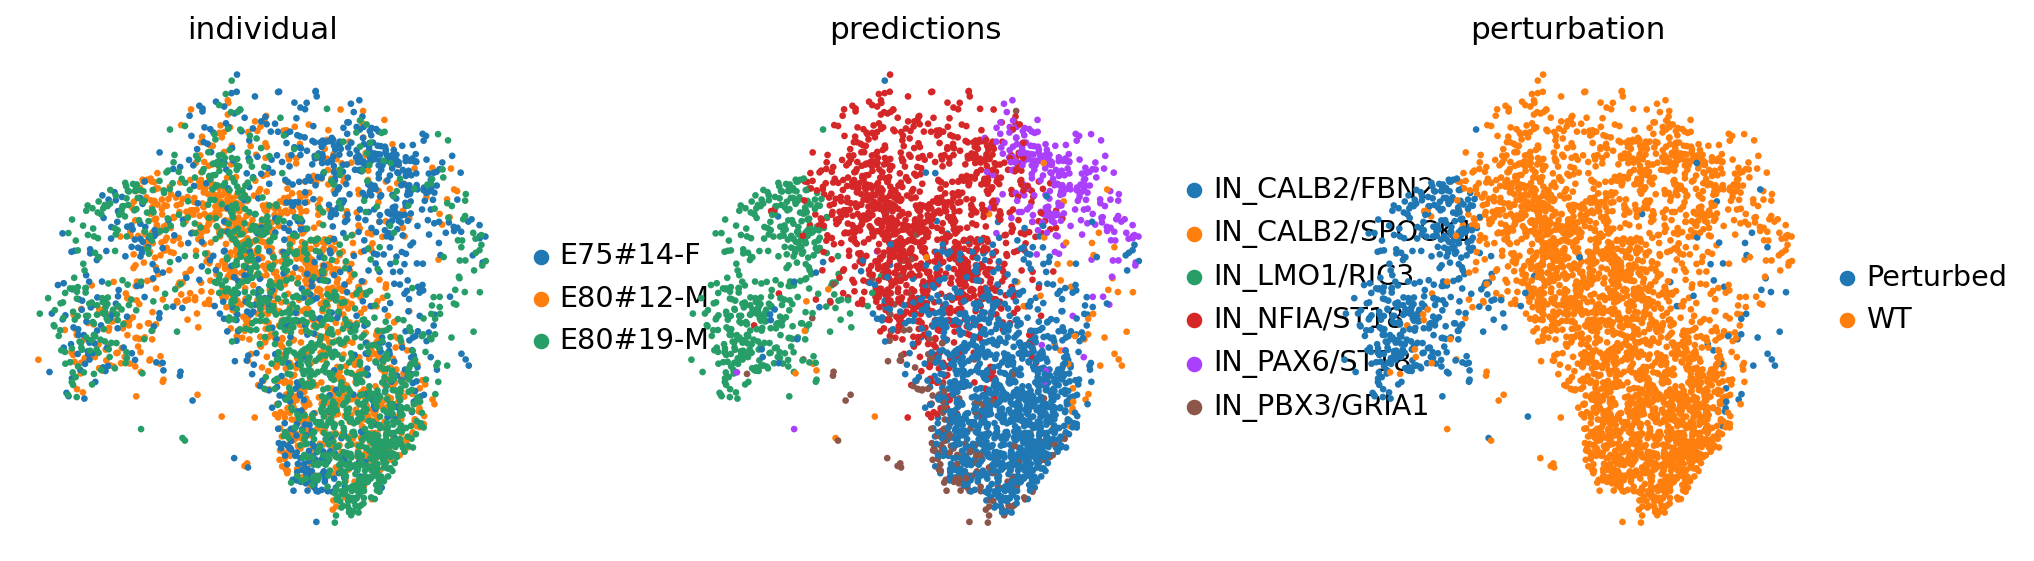

In [72]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual',min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Visualize
sc.pl.umap(adata, color=['individual','predictions','perturbation'], frameon=False)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


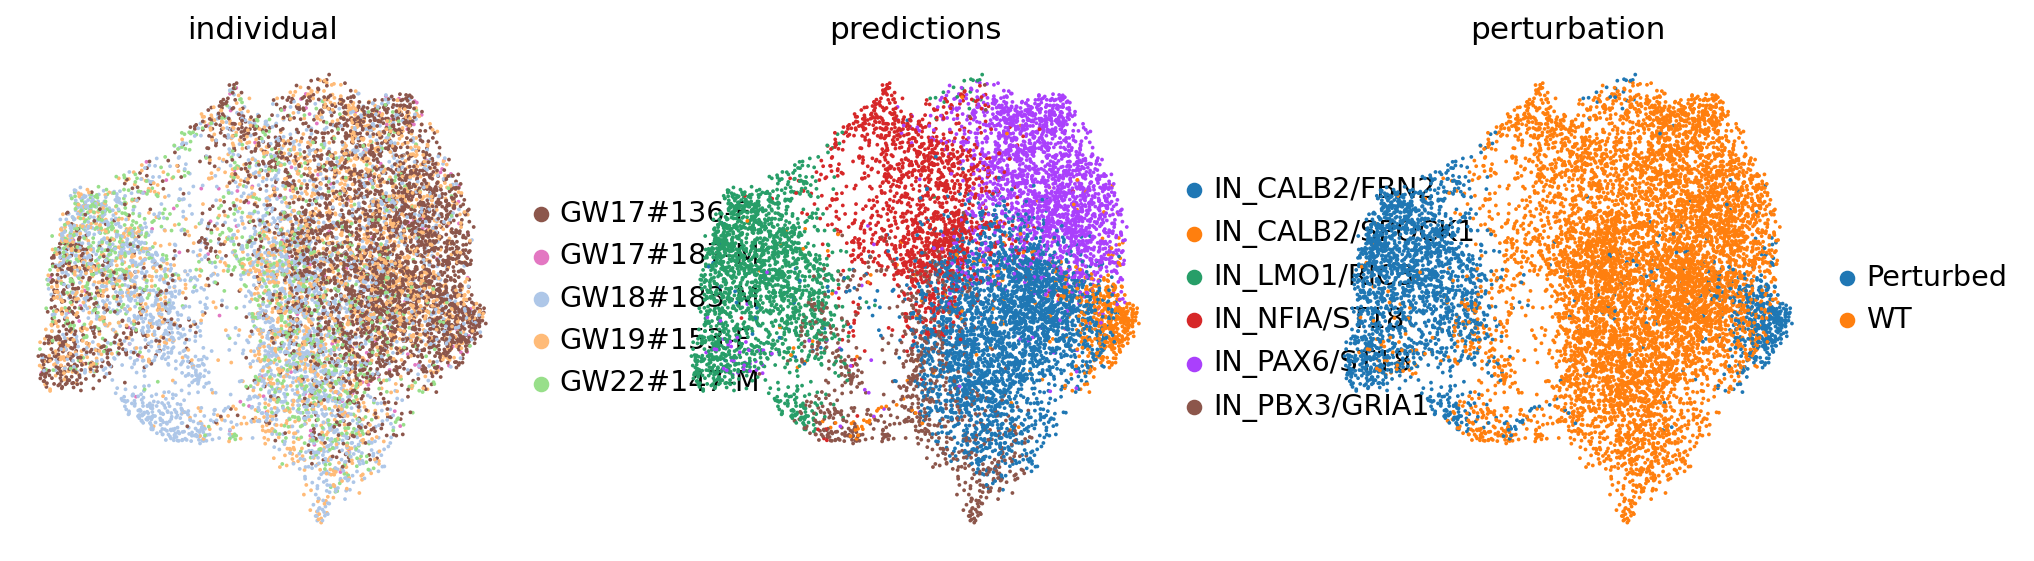

In [91]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual',min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Visualize
sc.pl.umap(adata, color=['individual','predictions','perturbation'], frameon=False)

In this data-set we have two condition, `COVID-19` and `healthy`, across 6 different cell types.

## Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach ([Squair J.W., et al 2021](https://doi.org/10.1038/s41467-021-25960-2)), which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

We can pseudobulk using the function `decoupler.get_pseudobulk`. In this example, we are interested in summing the counts but other
modes are available, for more information check its argument `mode`.

In [92]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='predictions',
    layer='counts',
    mode='sum',
    min_cells=2,
    min_counts=0
)

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

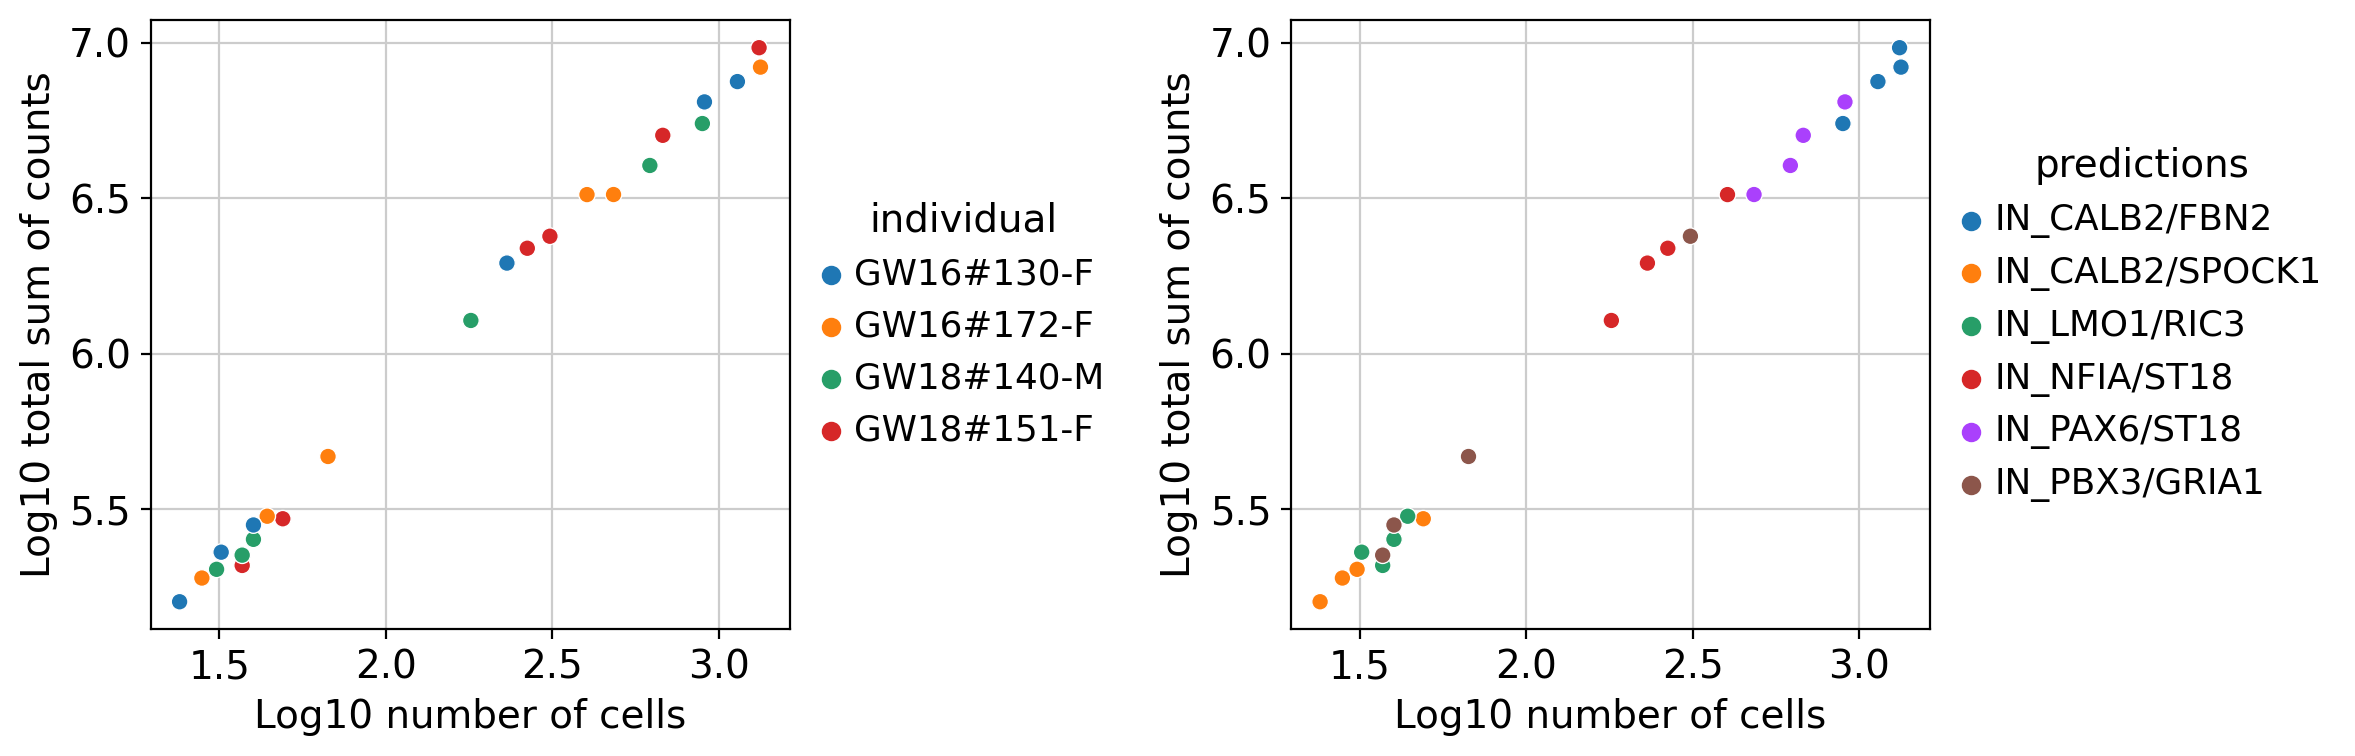

In [26]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'predictions'], figsize=(12, 4))

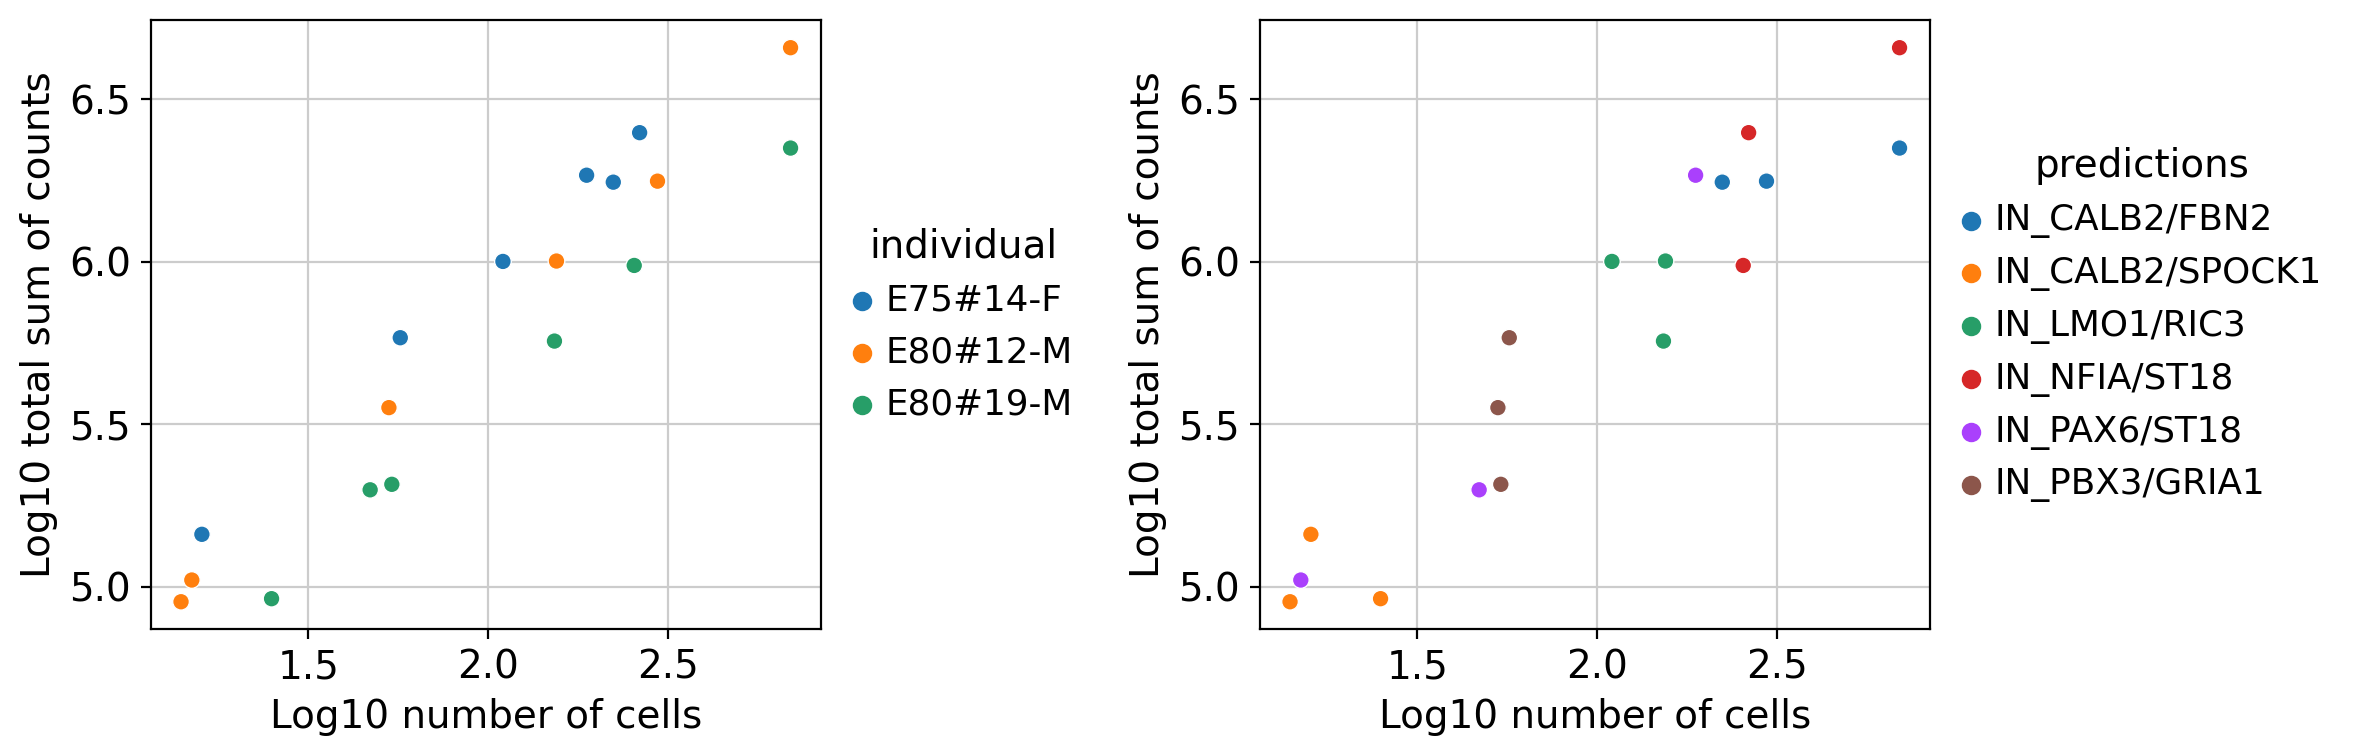

In [74]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'predictions'], figsize=(12, 4))

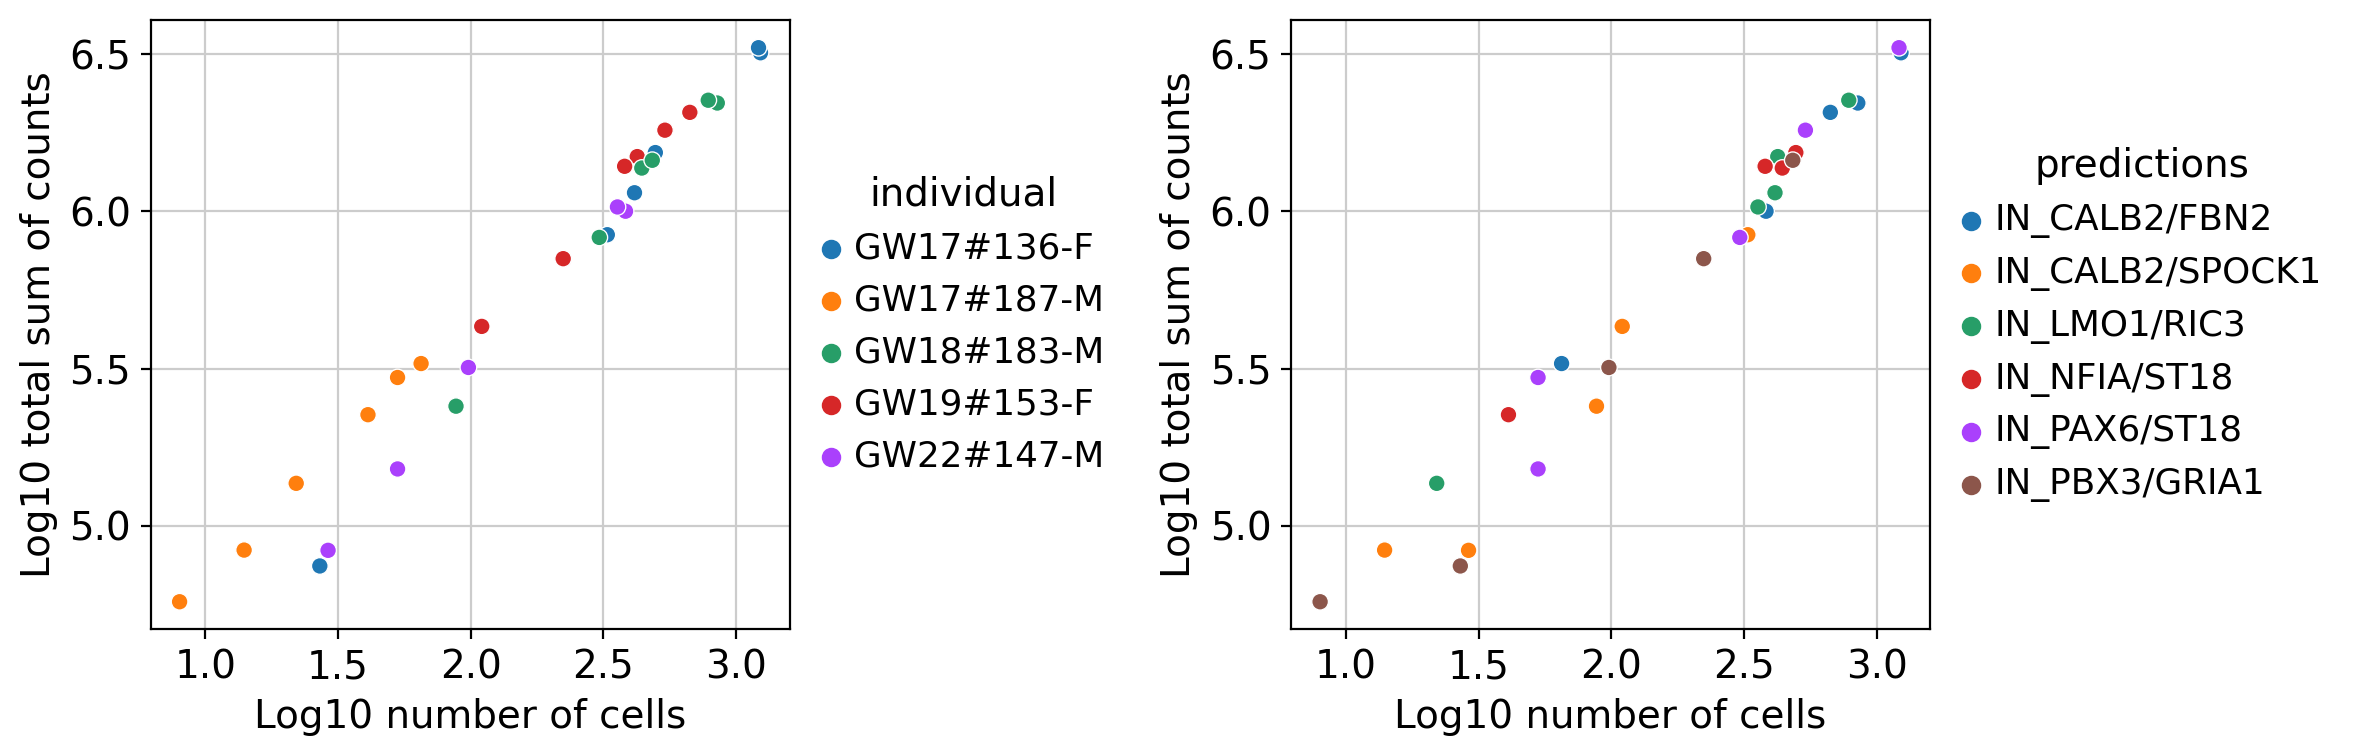

In [93]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'predictions'], figsize=(12, 4))

### Exploration of pseudobulk profiles
Now that we have generated the pseudobulk profiles for each patient and each cell type, let's explore the variability between them. For that, we will first do some simple preprocessing and then do a PCA

In [94]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


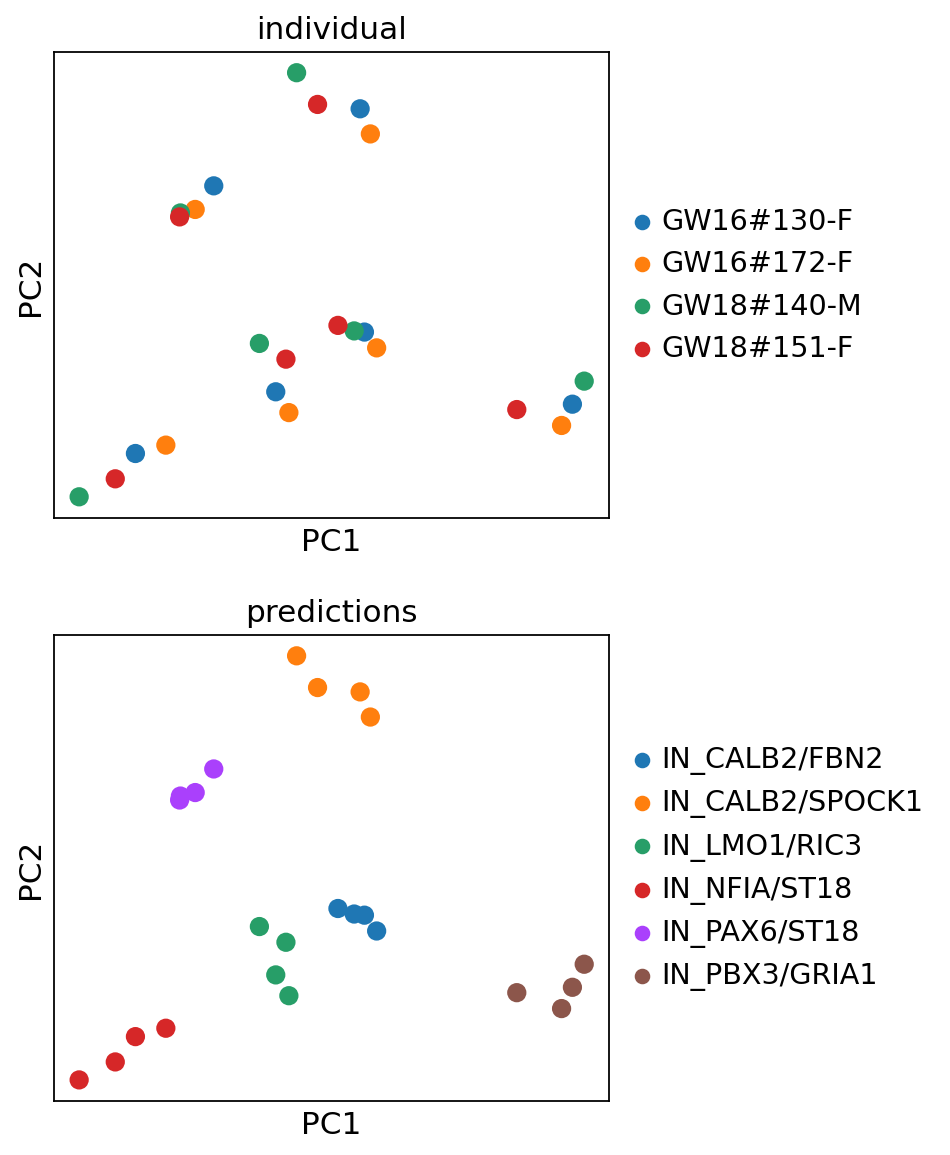

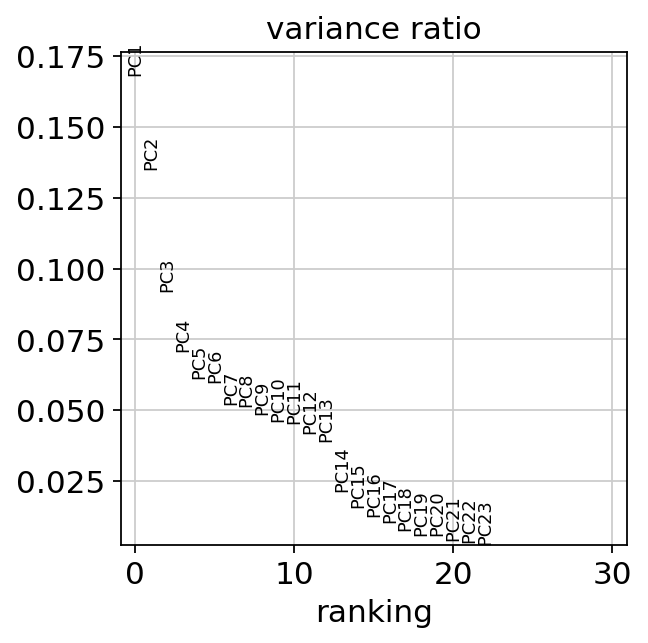

In [28]:
sc.pl.pca(pdata, color=['individual', 'predictions'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


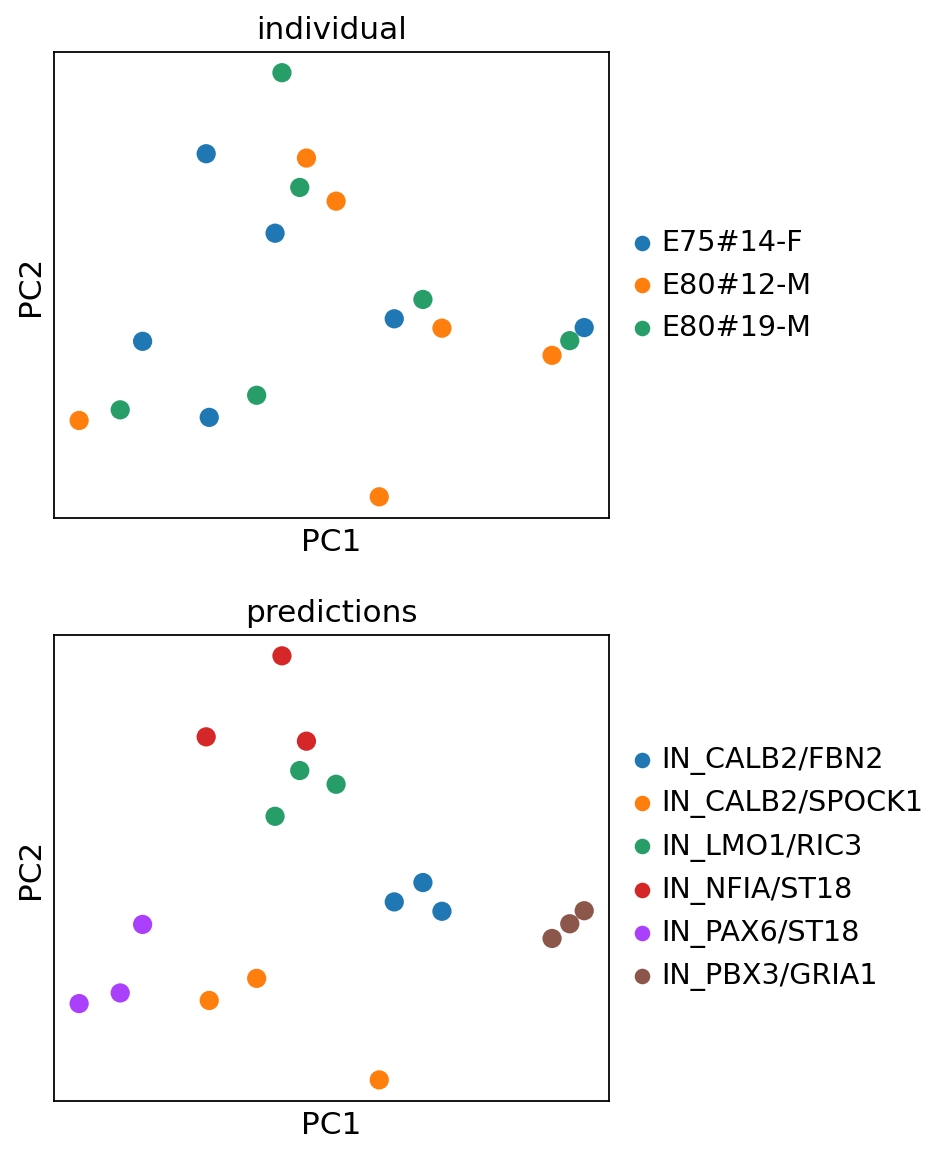

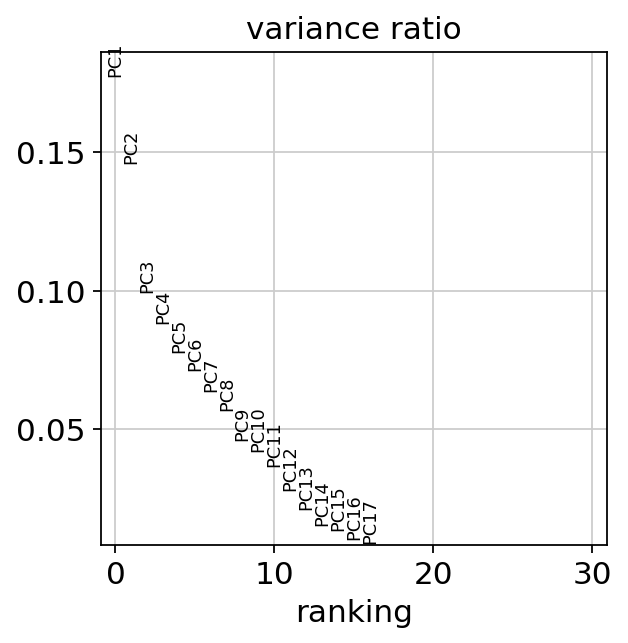

In [76]:
sc.pl.pca(pdata, color=['individual', 'predictions'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


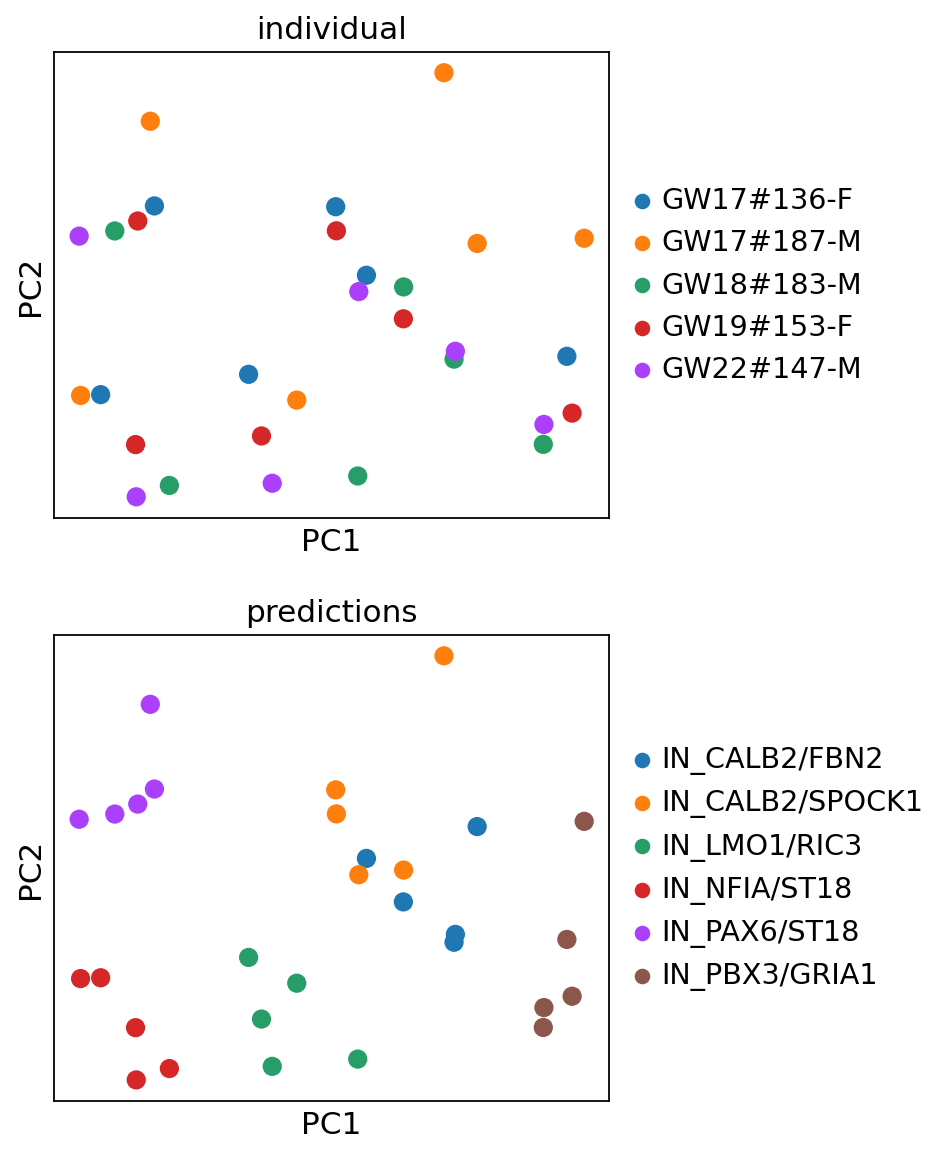

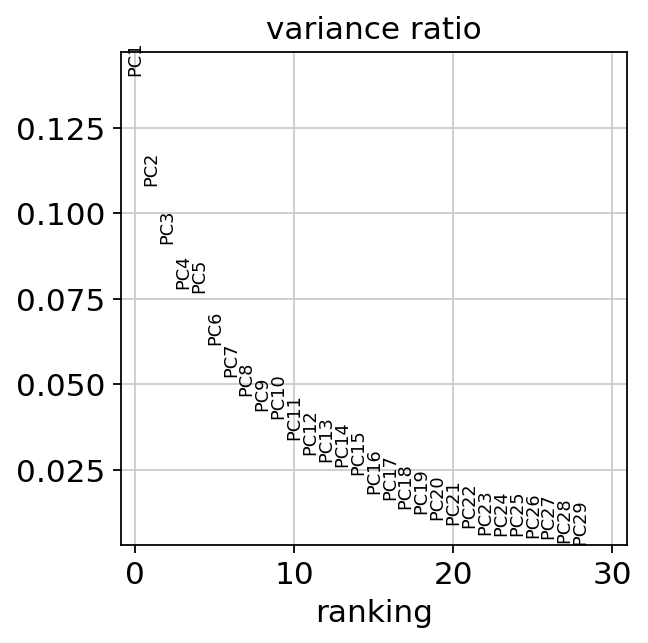

In [95]:
sc.pl.pca(pdata, color=['individual', 'predictions'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

When looking at the PCA, it seems like the two first components explain most of the variance and they easily separate cell types from one another. In contrast, the principle components do not seem to be associated with disease status as such.

In order to have a better overview of the association of PCs with sample metadata, let's perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples

In [15]:
pdata

AnnData object with n_obs × n_vars = 24 × 31557
    obs: 'GRCh38', 'rheMac10', 'call', 'species', 'individual-Q', 'individual', 'clone_barcode', 'clone_barcode_criteria', 'batch', 'timepoint', 'stage', 'sample_id', 'sex', 'species_batch', '_scvi_labels', 'labels_scanvi', 'predictions', 'class', 'leiden-.4', 'supervised_name', 'subtype', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids-HD0', 'feature_types-HD0', 'genome-HD0', 'mt-HD0', 'n_cells_by_counts-HD0', 'mean_counts-HD0', 'pct_dropout_by_counts-HD0', 'total_counts-HD0', 'gene_ids-HD7', 'feature_types-HD7', 'genome-HD7', 'mt-HD7', 'n_cells_by_counts-HD7', 'mean_counts-HD7', 'pct_dropout_by_counts-HD7', 'total_counts-HD7', 'gene_ids-HM2ndD7', 'feature_types-HM2ndD7', 'genome-HM2ndD7', 'mt-HM2ndD7', 'n_cells_by_counts-HM2ndD7', 'mean_counts-HM2ndD7', 'pct_dropout_by_counts-HM2ndD7', 'total_counts-HM2ndD7', 'feature_types-HMD7', 'mt-HMD7', 'n_cells_by_counts-HMD7', 'mean_counts-HMD7', 'pct_dropout_by_counts-HMD7', 'total_counts-H

In [18]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['sex',  'predictions', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 37.73it/s]


In [19]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['Gene_target', 'predictions'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    #figsize=(7, 5),
    #n_factors=10,
)

ImportError: PyComplexHeatmap is not installed. Please install it using "pip install PyComplexHeatmap"

On the PCA plots above, T and B cells seemed not to be that well separated. However when looking at the hierarchical clustering in the heatmap, one can see that the inclusion of more PCs helps to distinguish them.

When looking at the p-values from the ANOVA models, it becomes clear that the top PCs, which explain most of the observed variability, are statistically associated with the `cell_type` category.

### Pseudo-bulk profile gene filtering
Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

For this vignette, we will explore the effects of COVID on T cells. Let's first select our samples of interest:

In [14]:
# Select T cell profiles
#RG = pdata[pdata.obs['supervised_name'] == 'RG'].copy()

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

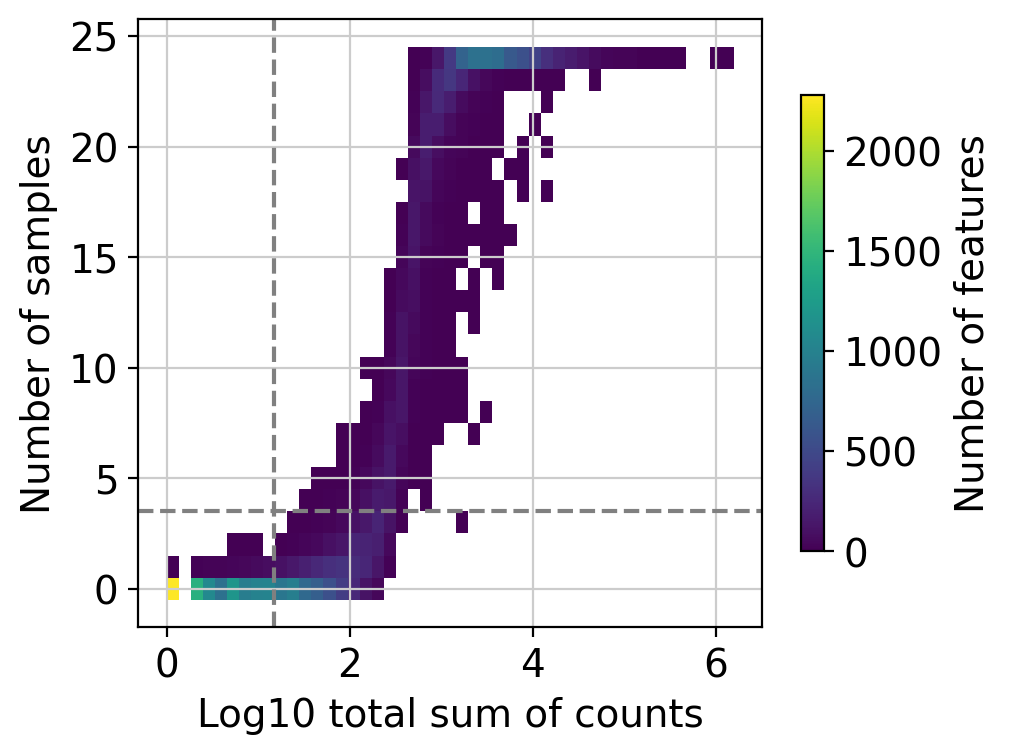

In [29]:
dc.plot_filter_by_expr(pdata, group='predictions', min_count=10, min_total_count=15)

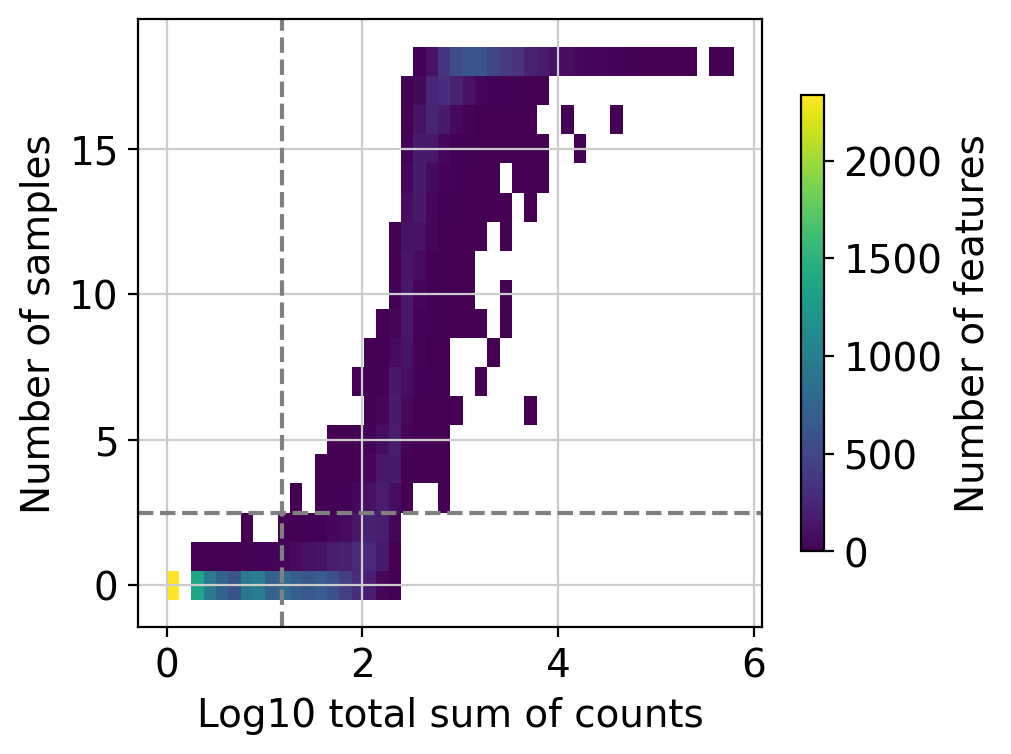

In [77]:
dc.plot_filter_by_expr(pdata, group='predictions', min_count=10, min_total_count=15)

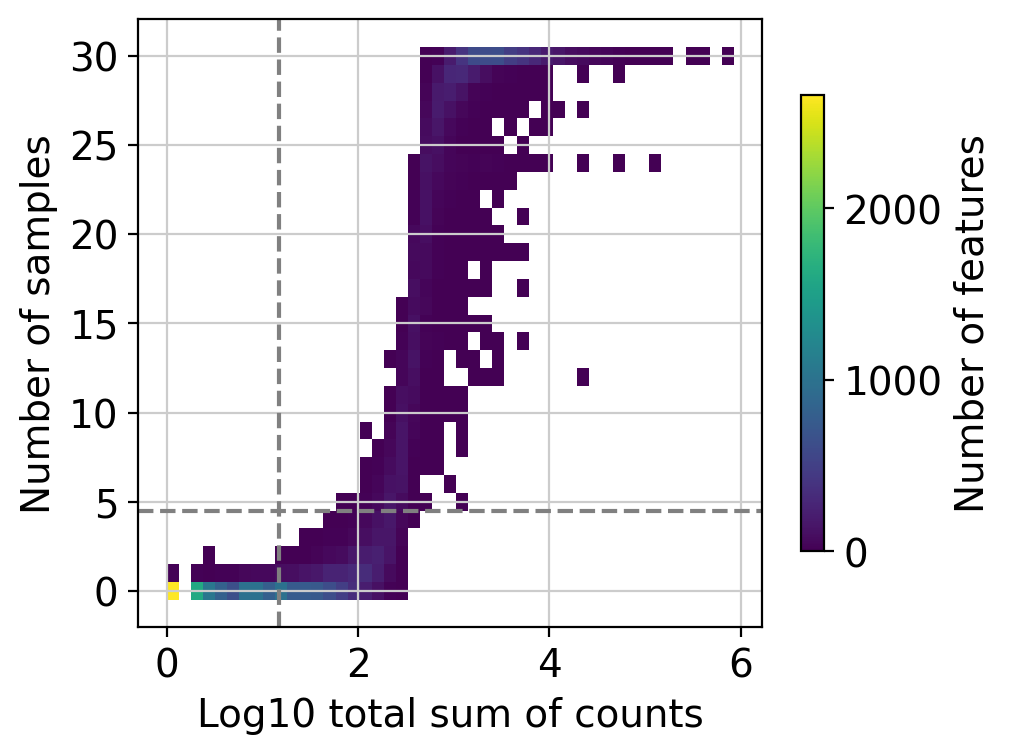

In [96]:
dc.plot_filter_by_expr(pdata, group='predictions', min_count=10, min_total_count=15)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.

<div class="alert alert-info">

**Note**
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters. 


</div>

Once we are content with the threshold parameters, we can perform the actual filtering:

In [30]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(pdata, group='predictions', min_count=10, min_total_count=15)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 24 × 13147
    obs: 'GRCh38', 'rheMac10', 'call', 'species', 'individual-Q', 'individual', 'clone_barcode', 'clone_barcode_criteria', 'batch', 'timepoint', 'stage', 'sample_id', 'sex', 'species_batch', '_scvi_labels', 'labels_scanvi', 'predictions', 'class', 'leiden-.4', 'supervised_name', 'subtype', 'perturbation', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids-HD0', 'feature_types-HD0', 'genome-HD0', 'mt-HD0', 'n_cells_by_counts-HD0', 'mean_counts-HD0', 'pct_dropout_by_counts-HD0', 'total_counts-HD0', 'gene_ids-HD7', 'feature_types-HD7', 'genome-HD7', 'mt-HD7', 'n_cells_by_counts-HD7', 'mean_counts-HD7', 'pct_dropout_by_counts-HD7', 'total_counts-HD7', 'gene_ids-HM2ndD7', 'feature_types-HM2ndD7', 'genome-HM2ndD7', 'mt-HM2ndD7', 'n_cells_by_counts-HM2ndD7', 'mean_counts-HM2ndD7', 'pct_dropout_by_counts-HM2ndD7', 'total_counts-HM2ndD7', 'feature_types-HMD7', 'mt-HMD7', 'n_cells_by_counts-HMD7', 'mean_counts-HMD7', 'pct_dropout_by_counts-HMD7',

In [97]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(pdata, group='predictions', min_count=10, min_total_count=15)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 30 × 10914
    obs: 'species', 'individual', 'timepoint', 'stage', 'sample_id', 'sex', '_scvi_batch', '_scvi_labels', 'labels_scanvi', 'predictions', 'class', 'leiden-.4', 'supervised_name', 'perturbation', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids-HD0', 'feature_types-HD0', 'genome-HD0', 'mt-HD0', 'n_cells_by_counts-HD0', 'mean_counts-HD0', 'pct_dropout_by_counts-HD0', 'total_counts-HD0', 'gene_ids-HD7', 'feature_types-HD7', 'genome-HD7', 'mt-HD7', 'n_cells_by_counts-HD7', 'mean_counts-HD7', 'pct_dropout_by_counts-HD7', 'total_counts-HD7', 'gene_ids-HM2ndD7', 'feature_types-HM2ndD7', 'genome-HM2ndD7', 'mt-HM2ndD7', 'n_cells_by_counts-HM2ndD7', 'mean_counts-HM2ndD7', 'pct_dropout_by_counts-HM2ndD7', 'total_counts-HM2ndD7', 'feature_types-HMD7', 'mt-HMD7', 'n_cells_by_counts-HMD7', 'mean_counts-HMD7', 'pct_dropout_by_counts-HMD7', 'total_counts-HMD7', 'gene_ids-0-HMD7', 'genome-0-HMD7', 'gene_ids-1-HMD7', 'genome-1-HMD7', 'highly_variable'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented
in `decoupler.filter_by_prop`.

## Contrast between conditions
Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple
experimental design where we compare the gene expression of T cells from diseased patients against controls. We will use the
python implementation of the framework DESeq2, but we could have used any other one (`limma` or `edgeR` for example).
For a better understanding how it works, check [DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that
more complex experimental designs can be used by adding more factors to the `design_factors` argument.

In [98]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [99]:
sub = pdata[pdata.obs['predictions'] != 'IN_CALB2/SPOCK1']
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)

In [101]:
dds = DeseqDataSet(
    adata= sub,
    design_factors='perturbation',
    ref_level=['perturbation', 'WT'],
    refit_cooks=True,
    inference=inference,
)

In [102]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.08 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 11.65 seconds.

Fitting LFCs...
... done in 5.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 10 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [103]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(
    dds,
    contrast=["perturbation", 'Perturbed', 'WT'],
    inference=inference,
)

In [104]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: perturbation Perturbed vs WT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.220782       -0.246347  0.325206 -0.757511  0.448744  0.932500
A2M        14.261259        0.015261  0.195571  0.078033  0.937802  0.997567
A2ML1-AS1  14.411122        0.065267  0.275805  0.236643  0.812934  0.992849
AAAS        8.235639       -0.372052  0.275122 -1.352317  0.176274  0.751598
AACS       30.341889       -0.173353  0.176914 -0.979872  0.327149  0.877261
...              ...             ...       ...       ...       ...       ...
ZWILCH      8.432425       -0.668148  0.265522 -2.516361  0.011857  0.189423
ZXDC       56.324315       -0.004137  0.149133 -0.027738  0.977871  0.997811
ZYG11B     93.343791       -0.170980  0.123631 -1.382990  0.166668  0.734769
ZZEF1      48.640473       -0.029677  0.154236 -0.192411  0.847420  0.995589
ZZZ3       80.309823        0.034957  0.104850  0.333403  0.738830  0.980893

[10914 r

... done in 1.12 seconds.



In [105]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.220782       -0.246347  0.325206 -0.757511  0.448744  0.932500
A2M        14.261259        0.015261  0.195571  0.078033  0.937802  0.997567
A2ML1-AS1  14.411122        0.065267  0.275805  0.236643  0.812934  0.992849
AAAS        8.235639       -0.372052  0.275122 -1.352317  0.176274  0.751598
AACS       30.341889       -0.173353  0.176914 -0.979872  0.327149  0.877261
...              ...             ...       ...       ...       ...       ...
ZWILCH      8.432425       -0.668148  0.265522 -2.516361  0.011857  0.189423
ZXDC       56.324315       -0.004137  0.149133 -0.027738  0.977871  0.997811
ZYG11B     93.343791       -0.170980  0.123631 -1.382990  0.166668  0.734769
ZZEF1      48.640473       -0.029677  0.154236 -0.192411  0.847420  0.995589
ZZZ3       80.309823        0.034957  0.104850  0.333403  0.738830  0.980893

[10914 rows x 6 columns]

In [67]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/'
stat_res.results_df.to_csv(os.path.join(dir, 'IN_LMO1RIC3.csv'))

In [86]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/'
stat_res.results_df.to_csv(os.path.join(dir, 'IN_LMO1RIC3_macaque.csv'))

In [106]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/'
stat_res.results_df.to_csv(os.path.join(dir, 'IN_LMO1RIC3_human.csv'))

We can plot the obtained results in a volcano plot:

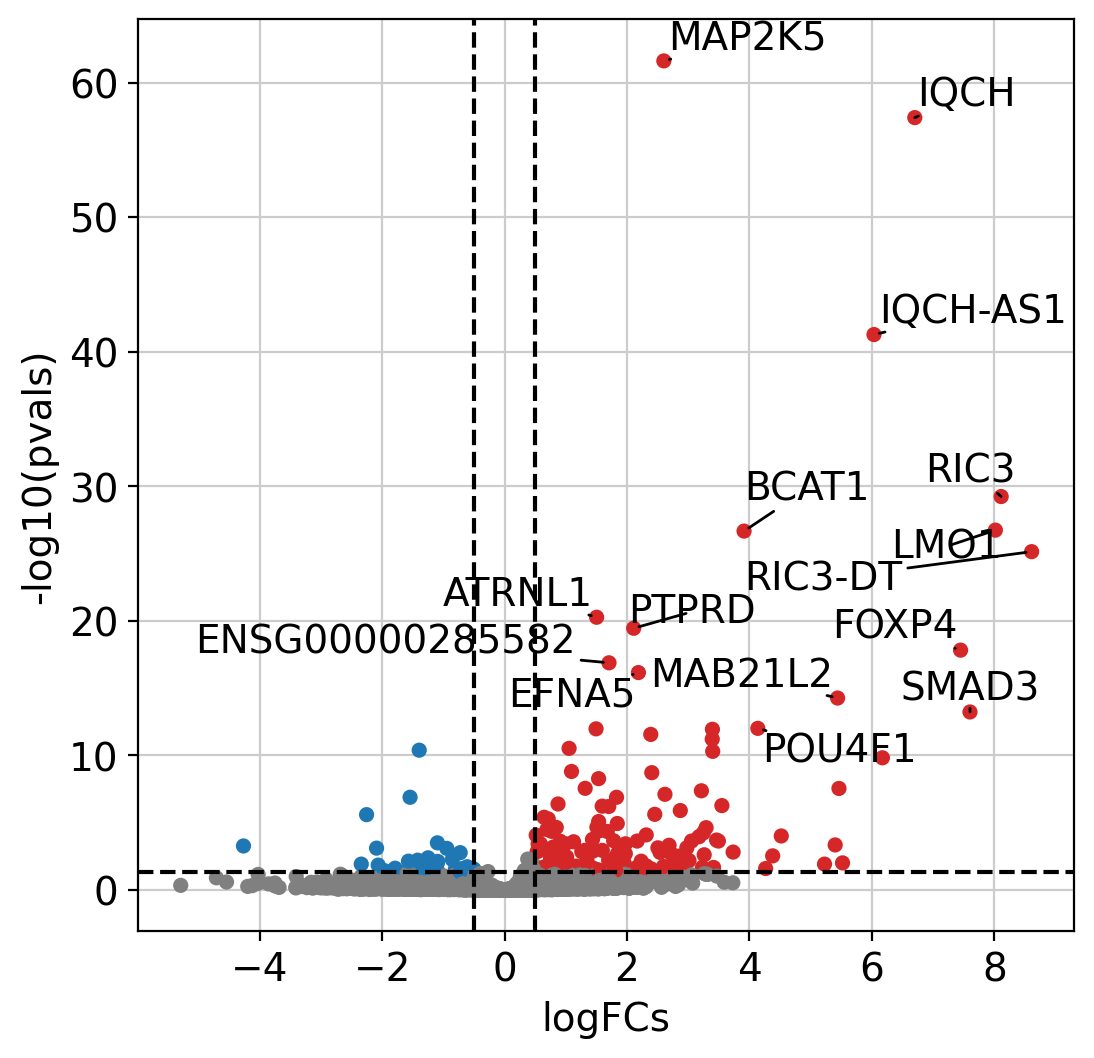

In [66]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange', #color_pos='#f43f03', color_neg='#316dd4',
    y='padj',
    top=15,
    figsize=(6, 6),
    save=None
)

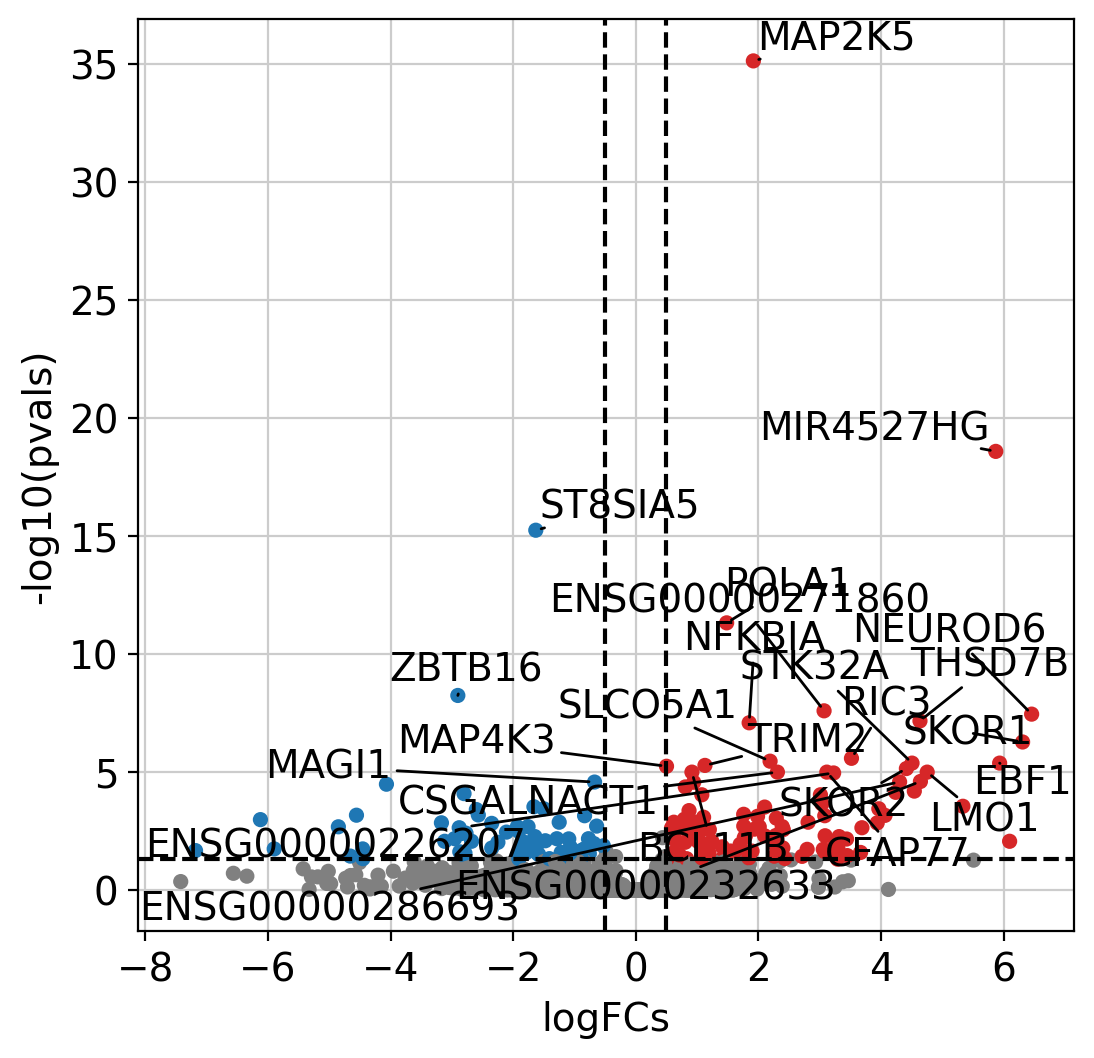

In [88]:
#macaque
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange', #color_pos='#f43f03', color_neg='#316dd4',
    y='padj',
    top=25,
    figsize=(6, 6),
    save=None
)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [108]:
mat = results_df[['stat']].T.rename(index={'stat': 'IN_LMO1/RIC3'})
mat

A1BG       A2M  A2ML1-AS1      AAAS      AACS     AADAT  \
IN_LMO1/RIC3 -0.757511  0.078033   0.236643 -1.352317 -0.979872 -0.234246   

                 AAGAB      AAK1     AAMDC      AAMP  ...    ZSWIM7    ZSWIM8  \
IN_LMO1/RIC3  3.543001 -0.924718 -0.547136  0.848238  ... -1.008886  0.399823   

                ZSWIM9      ZUP1      ZW10    ZWILCH      ZXDC   ZYG11B  \
IN_LMO1/RIC3  0.352565 -1.105927 -0.329459 -2.516361 -0.027738 -1.38299   

                 ZZEF1      ZZZ3  
IN_LMO1/RIC3 -0.192411  0.333403  

[1 rows x 10914 columns]

In [131]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/'
results_df = pd.read_csv(os.path.join(dir, 'IN_LMO1RIC3.csv'), index_col=0)
mat = results_df[['stat']].T.rename(index={'stat': 'IN_LMO1/RIC3'})
mat

A1BG  A1BG-AS1       A2M  A2ML1-AS1      AAAS      AACS  \
IN_LMO1/RIC3 -1.582318 -0.578233  1.198438   0.610574  0.545416 -2.054769   

                 AADAT     AAGAB      AAK1     AAMDC  ...    ZSWIM9      ZUP1  \
IN_LMO1/RIC3  1.099494  5.230041  0.072876 -0.943188  ...  1.097685  2.583294   

                  ZW10    ZWILCH      ZXDB      ZXDC   ZYG11B       ZYX  \
IN_LMO1/RIC3 -0.627997 -1.376272  2.741682  0.740212  0.19793 -1.804464   

                 ZZEF1      ZZZ3  
IN_LMO1/RIC3 -1.038884  1.595694  

[1 rows x 13147 columns]

## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [39]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="../ulm.png" />

We can run `ulm` with a one-liner:

In [109]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

ABL1      AHR      AIRE       AP1     APEX1        AR  \
IN_LMO1/RIC3 -1.394524 -2.17994 -0.501656 -0.416367  1.696676 -0.987023   

                ARID1A    ARID3B    ARID4A      ARNT  ...    ZNF331    ZNF350  \
IN_LMO1/RIC3  1.316572 -0.551737 -0.459907 -0.311617  ... -0.421891  0.070583   

               ZNF354C    ZNF362    ZNF382    ZNF384    ZNF436    ZNF699  \
IN_LMO1/RIC3 -0.675942 -3.112673 -0.503981 -0.337758  0.149275  0.764686   

                 ZNF76     ZNF91  
IN_LMO1/RIC3  0.258414  0.799328  

[1 rows x 526 columns]

Let us plot the obtained scores for the top active/inactive transcription factors:

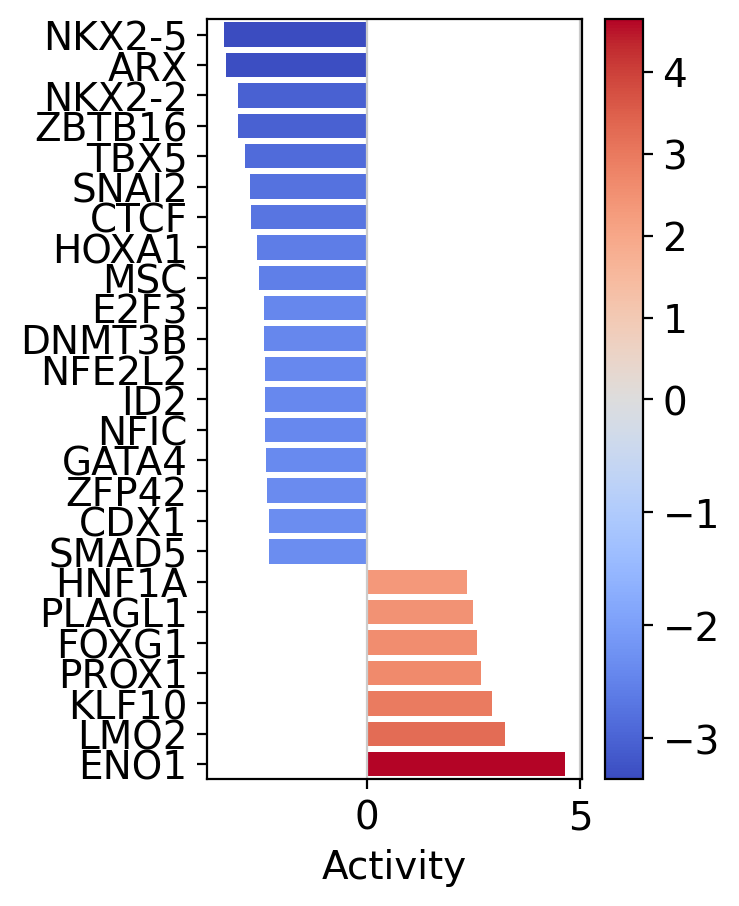

In [69]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='IN_LMO1/RIC3',
    top=25,
    vertical=True,
    figsize=(3, 5)
)

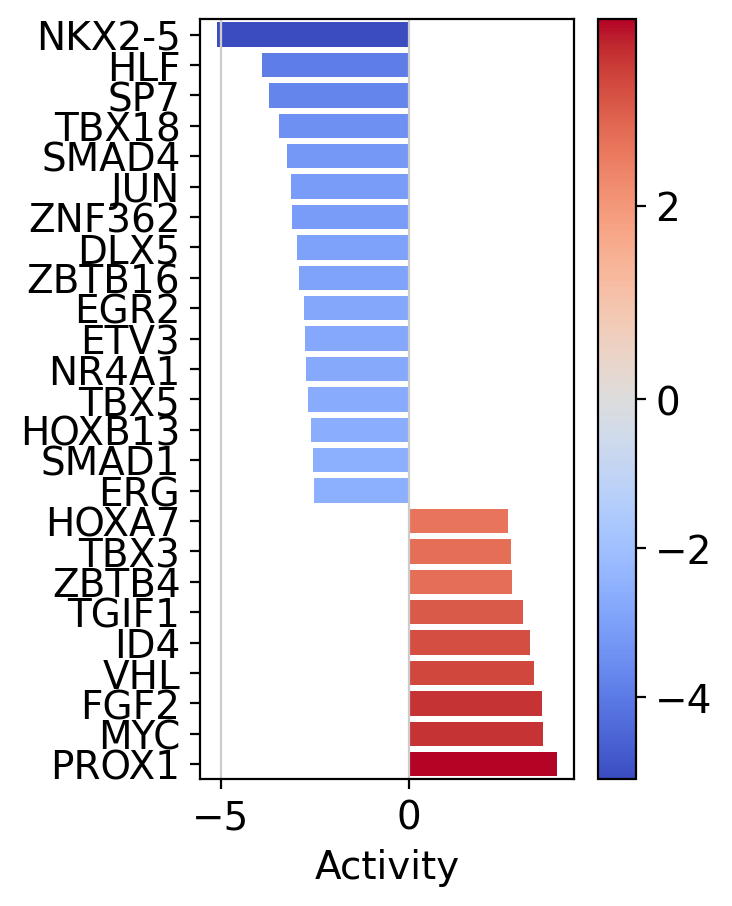

In [110]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='IN_LMO1/RIC3',
    top=25,
    vertical=True,
    figsize=(3, 5)
)

In accordance to the previous pathway results, T cells seem to activate for TFs responsible for cell growth (E2F4, TFDP1, E2F1).

Like with pathways, we can explore how the target genes look like:

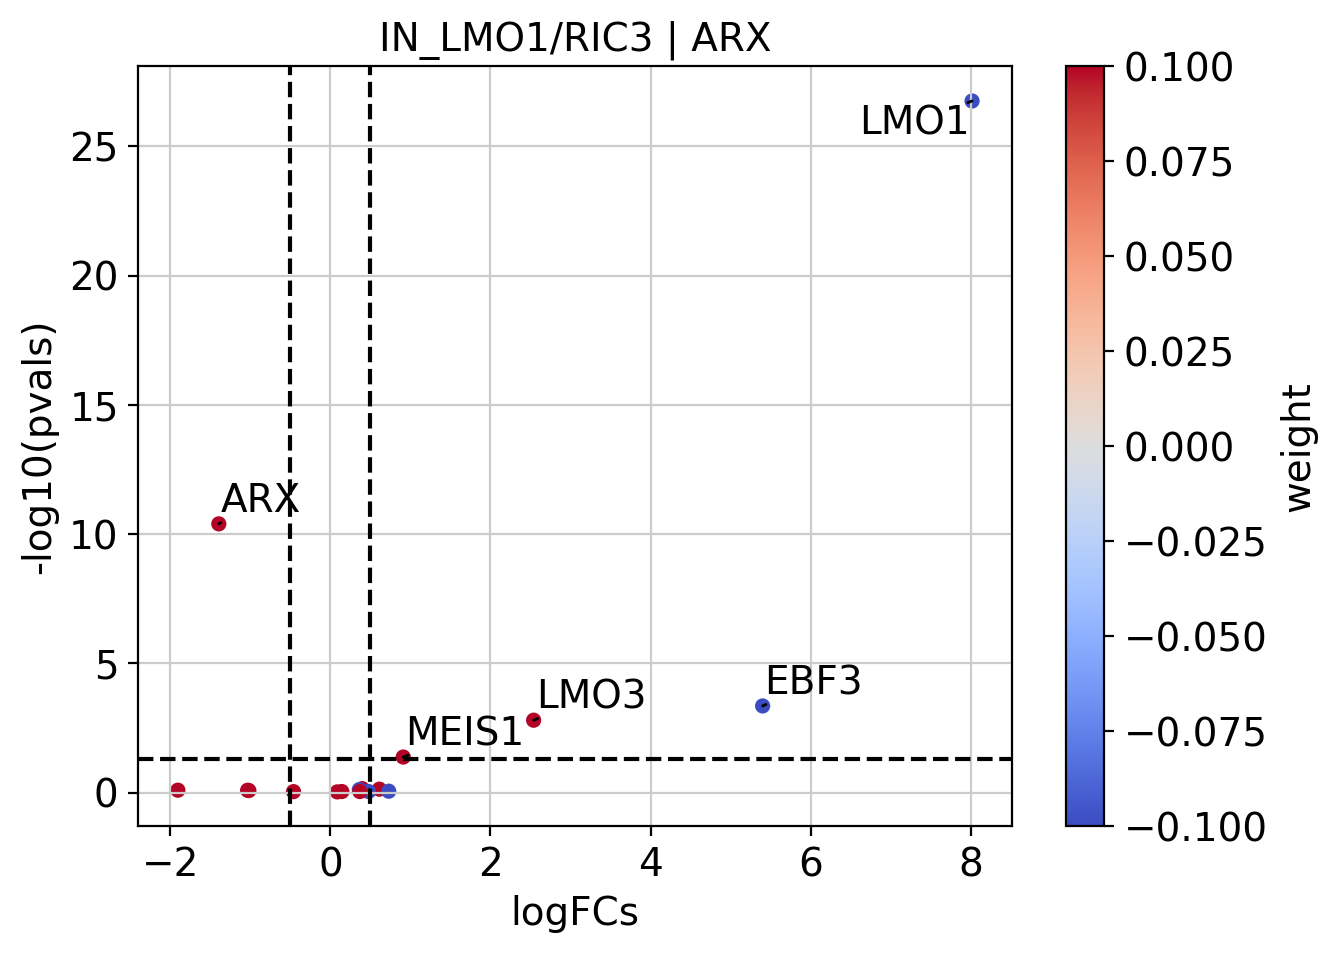

In [45]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'IN_LMO1/RIC3'})
pvals = results_df[['padj']].T.rename(index={'padj': 'IN_LMO1/RIC3'})

# Plot
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='IN_LMO1/RIC3',
    name='ARX',
    net=collectri,
    top=10,
    sign_thr=0.05,
    lFCs_thr=0.5
)

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

In [46]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['ARX', 'NKX2-5', 'CTCF', 'ZBTB16'],
    n_targets=15,
    node_size=100,
    figsize=(7, 7),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True
)

AttributeError: module 'decoupler' has no attribute 'plot_network'

Green edges are positive regulation (activation), red edges are negative regulation (inactivation):

## Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [47]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

0.00B [00:00, ?B/s]

source   target     weight       p_value
0     Androgen  TMPRSS2  11.490631  0.000000e+00
1     Androgen   NKX3-1  10.622551  2.242078e-44
2     Androgen   MBOAT2  10.472733  4.624285e-44
3     Androgen     KLK2  10.176186  1.944414e-40
4     Androgen     SARG  11.386852  2.790209e-40
...        ...      ...        ...           ...
6995       p53    ZMYM4  -2.325752  1.522388e-06
6996       p53    CFDP1  -1.628168  1.526045e-06
6997       p53   VPS37D   2.309503  1.537098e-06
6998       p53    TEDC1  -2.274823  1.547037e-06
6999       p53  CCDC138  -3.205113  1.568160e-06

[7000 rows x 4 columns]

### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="../mlm.png" />
     
We can run `mlm` with a one-liner:

In [111]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK  \
IN_LMO1/RIC3 -0.737476 -0.857402 -0.968864 -1.652691 -0.245356  0.811913   

                  NFkB      PI3K      TGFb      TNFa     Trail      VEGF  \
IN_LMO1/RIC3  0.858559  0.731186  0.402088 -1.492273 -1.834361  1.050772   

                  WNT       p53  
IN_LMO1/RIC3  0.12006 -0.713764

Let us plot the obtained scores:

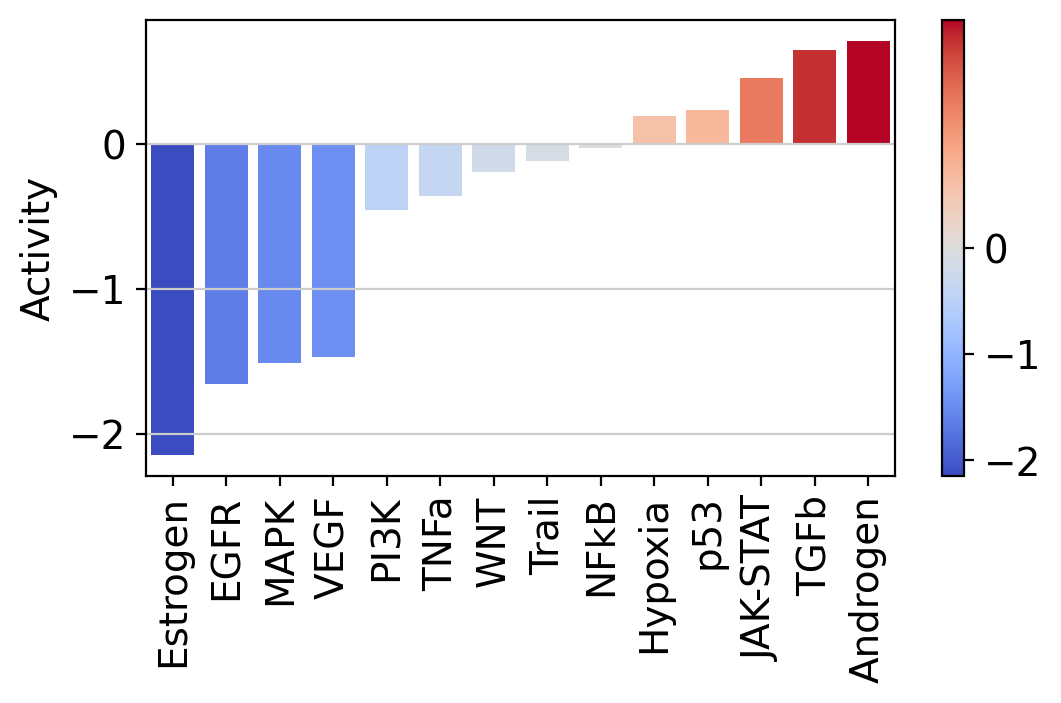

In [49]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='IN_LMO1/RIC3',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

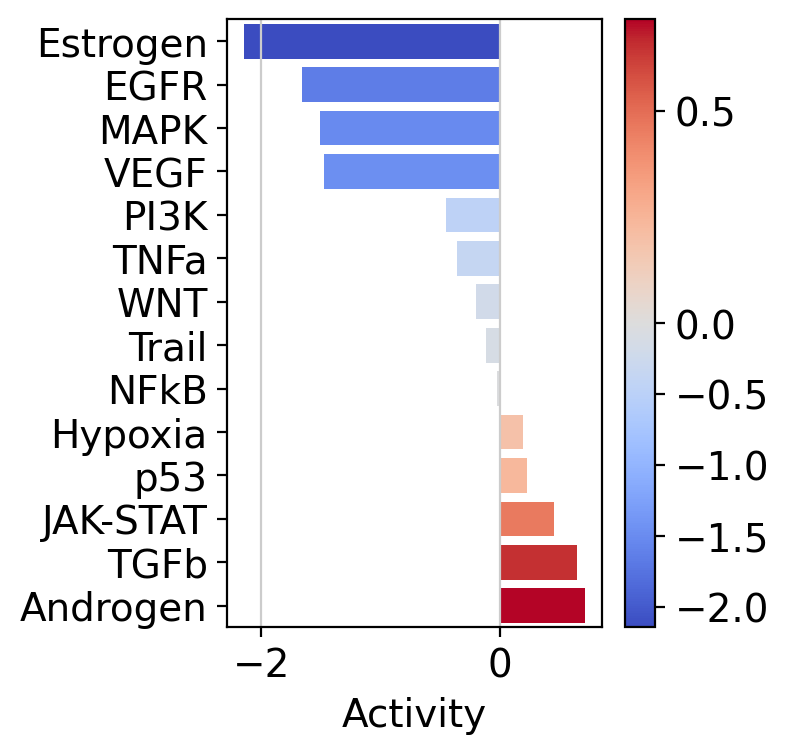

In [61]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='IN_LMO1/RIC3',
    top=25,
    vertical=True,
    figsize=(3, 4)
)

It looks like JAK-STAT, a known immunity pathway is more active in T cells from COVID-19 patients than in controls. To further explore how the target genes of a pathway of interest behave, we can plot them in scatter plot:

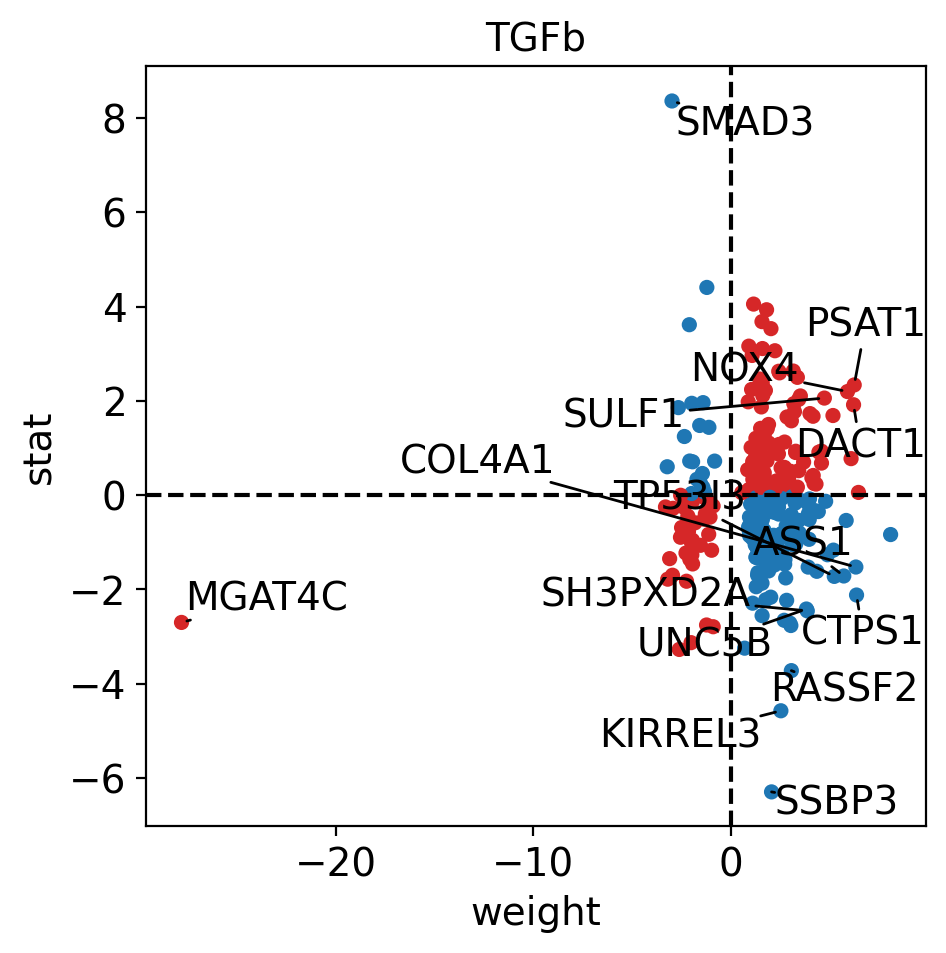

In [52]:
dc.plot_targets(
    data=results_df,
    stat='stat',
    source_name='TGFb',
    net=progeny,
    top=15
)

The observed activation of JAK-STAT is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [114]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [54]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

genesymbol collection                  geneset
233           MAFF   hallmark      IL2_STAT5_SIGNALING
250           MAFF   hallmark              COAGULATION
270           MAFF   hallmark                  HYPOXIA
373           MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               COMPLEMENT
...            ...        ...                      ...
1449668     STXBP1   hallmark      PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      PANCREAS_BETA_CELLS
1450526        GCG   hallmark      PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

In [116]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='go_biological_process']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']]

msigdb

genesymbol             collection  \
33            MAFF  go_biological_process   
44            MAFF  go_biological_process   
82            MAFF  go_biological_process   
94            MAFF  go_biological_process   
108           MAFF  go_biological_process   
...            ...                    ...   
3838543   PRAMEF22  go_biological_process   
3838544   PRAMEF22  go_biological_process   
3838545   PRAMEF22  go_biological_process   
3838546   PRAMEF22  go_biological_process   
3838547   PRAMEF22  go_biological_process   

                                                   geneset  
33                                      EMBRYO_DEVELOPMENT  
44            POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS  
82           REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION  
94       EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG_HATC...  
108                         IN_UTERO_EMBRYONIC_DEVELOPMENT  
...                                                    ...  
3838543  POSITIVE_REGULATION_OF_CELL_POPULATION_PROLIFE...  
3838544                                  APOPTOTIC_PROCESS  
3838545                           REGULATION_OF_CELL_DEATH  
3838546       NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547                  NEGATIVE_REGULATION_OF_CELL_DEATH  

[620627 rows x 3 columns]

### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [55]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

Term  Set size  Overlap ratio   p-value  FDR p-value  \
0      ALLOGRAFT_REJECTION       200       0.005000  0.861873     0.861873   
1        ANDROGEN_RESPONSE       100       0.030000  0.075287     0.695611   
2           APICAL_SURFACE        44       0.022727  0.351955     0.840337   
3                APOPTOSIS       161       0.006211  0.796480     0.861873   
4  CHOLESTEROL_HOMEOSTASIS        74       0.027027  0.163944     0.772877   

   Odds ratio  Combined score             Features  
0    0.757716        0.112633                BCAT1  
1    3.581665        9.263773  ARID5B;LMAN1;PDLIM5  
2    3.440875        3.593137                EFNA5  
3    0.942546        0.214480               CTNNB1  
4    3.437915        6.216550          CTNNB1;PDK3

In [132]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

Term  Set size  Overlap ratio  \
0                ACETYL_COA_BIOSYNTHETIC_PROCESS        17       0.058824   
1  ACETYL_COA_BIOSYNTHETIC_PROCESS_FROM_PYRUVATE        10       0.100000   
2                   ACETYL_COA_METABOLIC_PROCESS        32       0.031250   
3                    ACIDIC_AMINO_ACID_TRANSPORT        61       0.016393   
4                                 ACID_SECRETION        47       0.042553   

    p-value  FDR p-value  Odds ratio  Combined score      Features  
0  0.154214     0.378069    8.761491       16.378847          PDK3  
1  0.093809     0.321112   14.607600       34.568739          PDK3  
2  0.270497     0.475369    4.714185        6.163761          PDK3  
3  0.452096     0.617857    2.487618        1.974820        SLC6A1  
4  0.077534     0.307850    5.399405       13.806457  KCNQ1;SLC6A1

In [133]:
enr_pvals.sort_values('Combined score', ascending=False).head(20)

Term  Set size  \
611                               FOREGUT_MORPHOGENESIS        10   
1686               PRESYNAPTIC_ACTIVE_ZONE_ORGANIZATION         8   
700   HEPARAN_SULFATE_PROTEOGLYCAN_BIOSYNTHETIC_PROC...         8   
321   CELL_MOTILITY_INVOLVED_IN_CEREBRAL_CORTEX_RADI...         8   
1987                  REGULATION_OF_LUNG_BLOOD_PRESSURE         3   
1423   POSITIVE_REGULATION_OF_CARDIAC_MUSCLE_ADAPTATION         3   
184               CARDIAC_MUSCLE_MYOBLAST_PROLIFERATION         3   
2145  REGULATION_OF_SECONDARY_HEART_FIELD_CARDIOBLAS...         9   
143           CALCIUM_ION_EXPORT_ACROSS_PLASMA_MEMBRANE         9   
1588                POSITIVE_REGULATION_OF_OSSIFICATION        51   
2446                         SYNAPTIC_MEMBRANE_ADHESION        27   
36                            ADRENAL_GLAND_DEVELOPMENT        28   
1262                          NK_T_CELL_DIFFERENTIATION        10   
1342                    PARAXIAL_MESODERM_MORPHOGENESIS        10   
191                           CARDIOBLAST_PROLIFERATION        10   
430           DETERMINATION_OF_DORSAL_VENTRAL_ASYMMETRY        10   
1360                            PERICARDIUM_DEVELOPMENT        19   
1807            REGULATION_OF_CARDIAC_MUSCLE_ADAPTATION        11   
881               MESENCHYMAL_STEM_CELL_DIFFERENTIATION        11   
1453  POSITIVE_REGULATION_OF_CHONDROCYTE_DIFFERENTIA...        21   

      Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score  \
611        0.300000  0.000106     0.008068   34.436693      315.255329   
1686       0.250000  0.002574     0.058236   30.232119      180.257807   
700        0.250000  0.002574     0.058236   30.232119      180.257807   
321        0.250000  0.002574     0.058236   30.232119      180.257807   
1987       0.333333  0.029114     0.248124   43.838144      155.034784   
1423       0.333333  0.029114     0.248124   43.838144      155.034784   
184        0.333333  0.029114     0.248124   43.838144      155.034784   
2145       0.222222  0.003288     0.070766   27.048437      154.652247   
143        0.222222  0.003288     0.070766   27.048437      154.652247   
1588       0.117647  0.000010     0.002014   13.217313      151.857735   
2446       0.148148  0.000132     0.009345   16.978654      151.720868   
36         0.142857  0.000152     0.010527   16.382092      143.990175   
1262       0.200000  0.004083     0.076207   24.471172      134.613786   
1342       0.200000  0.004083     0.076207   24.471172      134.613786   
191        0.200000  0.004083     0.076207   24.471172      134.613786   
430        0.200000  0.004083     0.076207   24.471172      134.613786   
1360       0.157895  0.000800     0.031219   18.534486      132.167943   
1807       0.181818  0.004958     0.089285   22.342126      118.562736   
881        0.181818  0.004958     0.089285   22.342126      118.562736   
1453       0.142857  0.001082     0.035480   16.808665      114.780854   

                                 Features  
611                    CTNNB1;SMAD2;SMAD3  
1686                          ERC1;PCDH17  
700                     CSGALNACT1;HS2ST1  
321                         BMERB1;SRGAP2  
1987                                SMAD3  
1423                               PPP3CA  
184                                 MEIS2  
2145                          CTNNB1;EYA1  
143                          CALM2;SLC8A2  
1588  ACVR1;FBN2;NELL1;SMAD3;SOX11;ZBTB16  
2446             CDH10;EFNA5;PCDH17;PTPRD  
36              ARID5B;CDKN1C;SMAD2;SMAD3  
1262                           TOX;ZBTB16  
1342                          SMAD2;SMAD3  
191                           CTNNB1;EYA1  
430                          ACVR1;CTNNB1  
1360                     SMAD2;SMAD3;SOS1  
1807                         PPP3CA;SMAD3  
881                           CTNNB1;SOX5  
1453                    SMAD3;SOX5;ZBTB16

In [127]:
enr_pvals.sort_values('Combined score', ascending=False).head(20)

Term  Set size  \
306                  CELLULAR_RESPONSE_TO_HYDROPEROXIDE         9   
2173                                     PROPRIOCEPTION         5   
2472  REGULATION_OF_FC_GAMMA_RECEPTOR_SIGNALING_PATH...         5   
2615               REGULATION_OF_MONOCYTE_EXTRAVASATION         5   
2342            REGULATION_OF_CARDIAC_MUSCLE_ADAPTATION        11   
3169  SUBSTRATE_INDEPENDENT_TELENCEPHALIC_TANGENTIAL...        11   
2478           REGULATION_OF_FOCAL_ADHESION_DISASSEMBLY         6   
1960  POSITIVE_REGULATION_OF_LONG_TERM_SYNAPTIC_DEPR...         6   
1320  NEGATIVE_REGULATION_OF_CELLULAR_RESPONSE_TO_OX...         2   
976     IONOTROPIC_GLUTAMATE_RECEPTOR_SIGNALING_PATHWAY        26   
1010         LIGAND_GATED_ION_CHANNEL_SIGNALING_PATHWAY        35   
759                            FOREBRAIN_CELL_MIGRATION        66   
3188                         SYNAPTIC_MEMBRANE_ADHESION        27   
3204                 TELENCEPHALON_GLIAL_CELL_MIGRATION        27   
2931                              RESPONSE_TO_FORSKOLIN        13   
1306   NEGATIVE_REGULATION_OF_CARDIAC_MUSCLE_ADAPTATION         7   
2783        REGULATION_OF_SA_NODE_CELL_ACTION_POTENTIAL         7   
478                   CORTICOSPINAL_TRACT_MORPHOGENESIS         7   
2947                         RESPONSE_TO_INTERLEUKIN_12         7   
3201                                  TAURINE_TRANSPORT         7   

      Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score  \
306        0.333333  0.000562     0.035435   19.056376      142.613660   
2173       0.400000  0.003630     0.104534   23.455132      131.786139   
2472       0.400000  0.003630     0.104534   23.455132      131.786139   
2615       0.400000  0.003630     0.104534   23.455132      131.786139   
2342       0.272727  0.001073     0.055134   15.740649      107.628774   
3169       0.272727  0.001073     0.055134   15.740649      107.628774   
2478       0.333333  0.005374     0.133999   19.845658      103.715505   
1960       0.333333  0.005374     0.133999   19.845658      103.715505   
1320       0.500000  0.038523     0.323377   30.885714      100.579603   
976        0.192308  0.000127     0.011202   10.781927       96.693428   
1010       0.171429  0.000052     0.005770    9.532347       93.946366   
759        0.136364  0.000005     0.001396    7.484325       91.276778   
3188       0.185185  0.000154     0.012853   10.389337       91.211021   
3204       0.185185  0.000154     0.012853   10.389337       91.211021   
2931       0.230769  0.001806     0.078372   13.407359       84.687779   
1306       0.285714  0.007428     0.159306   17.198710       84.317275   
2783       0.285714  0.007428     0.159306   17.198710       84.317275   
478        0.285714  0.007428     0.159306   17.198710       84.317275   
2947       0.285714  0.007428     0.159306   17.198710       84.317275   
3201       0.285714  0.007428     0.159306   17.198710       84.317275   

                                               Features  
306                                    DAPK1;MGST1;OXR1  
2173                                    POU4F1;TMEM150C  
2472                                         CD47;PTPRJ  
2615                                         CD47;PLCB1  
2342                                  MLIP;PPP3CA;SMAD3  
3169                                     ARX;NRG3;SLIT1  
2478                                      IQSEC1;PIK3R1  
1960                                        ADCY8;GRID2  
1320                                               OXR1  
976                       GRIA1;GRIA3;GRIA4;GRID1;GRID2  
1010                GRIA1;GRIA3;GRIA4;GRID1;GRID2;PLCB1  
759   ARX;CTNNB1;CXCR4;LAMB1;LRP8;NRG3;P2RY12;SLIT1;...  
3188                      CDH10;CDH6;EFNA5;PCDH17;PTPRD  
3204                    CTNNB1;LAMB1;LRP8;P2RY12;SRGAP2  
2931                                  ADCY2;ADCY8;EFNA5  
1306                                         MLIP;SMAD3  
2783                                          ANK2;HCN1  
47

Then we can visualize the most enriched terms:

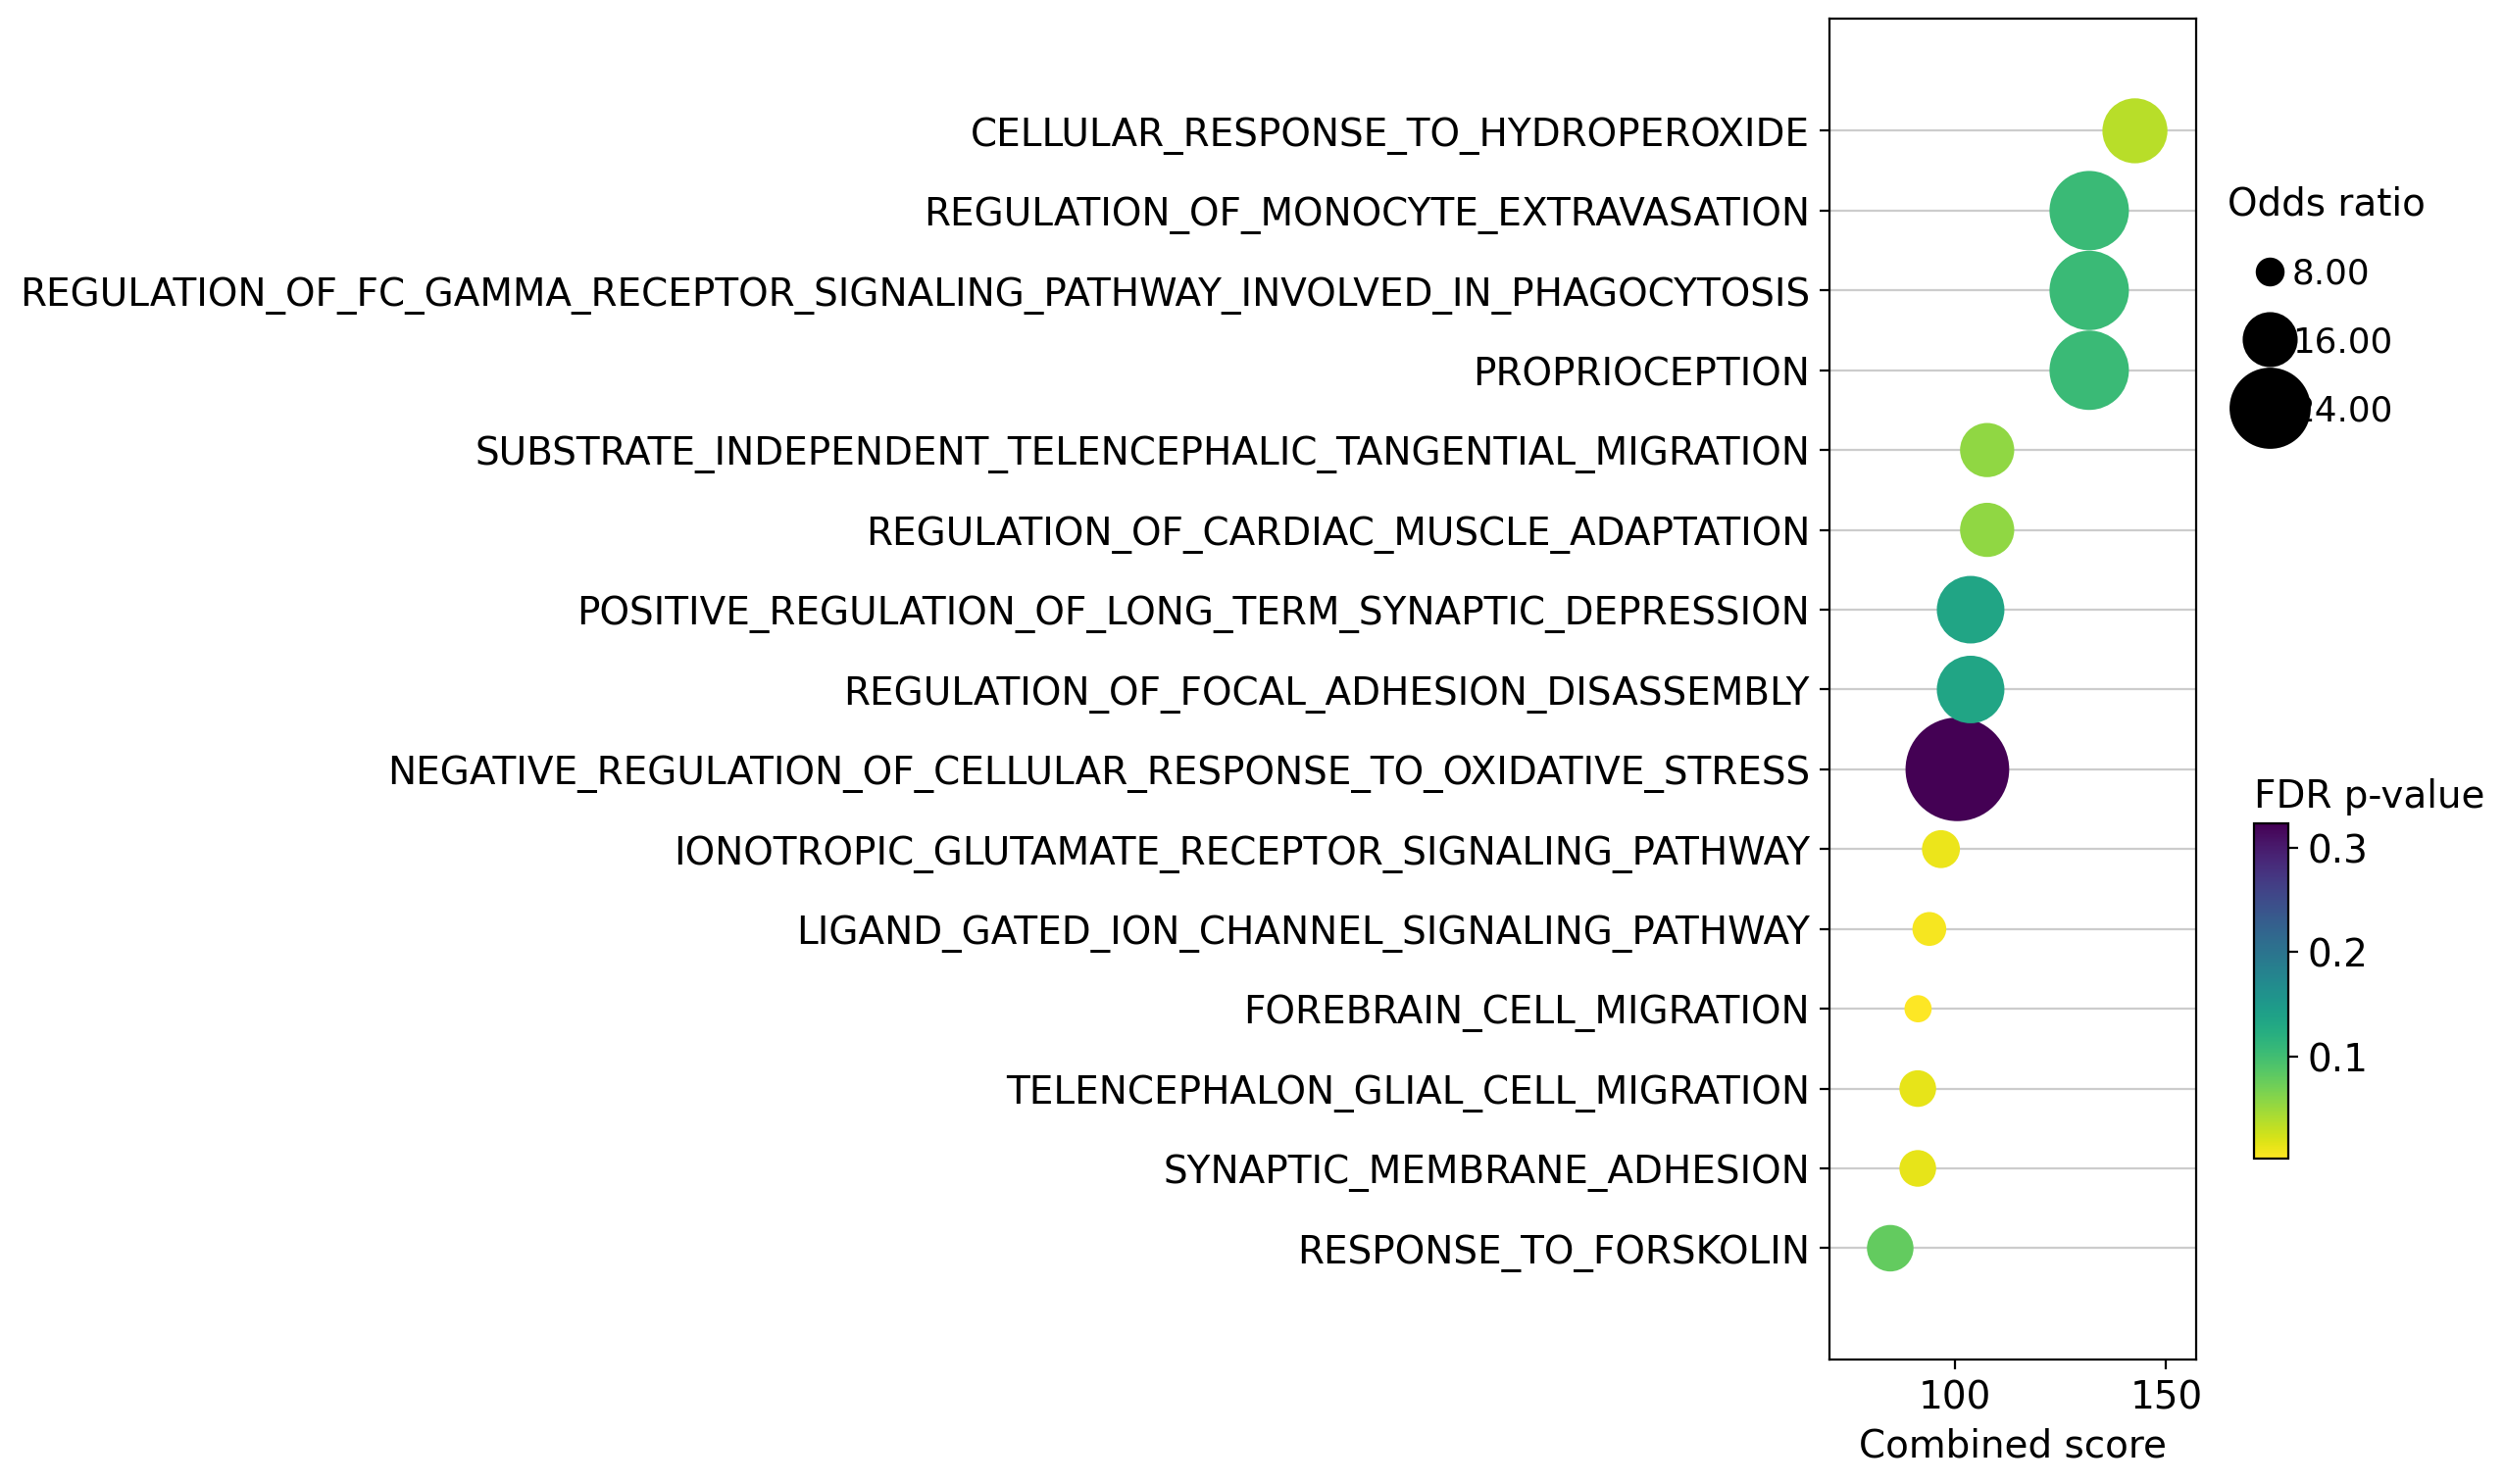

In [121]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.2,
    figsize=(3, 9)
)

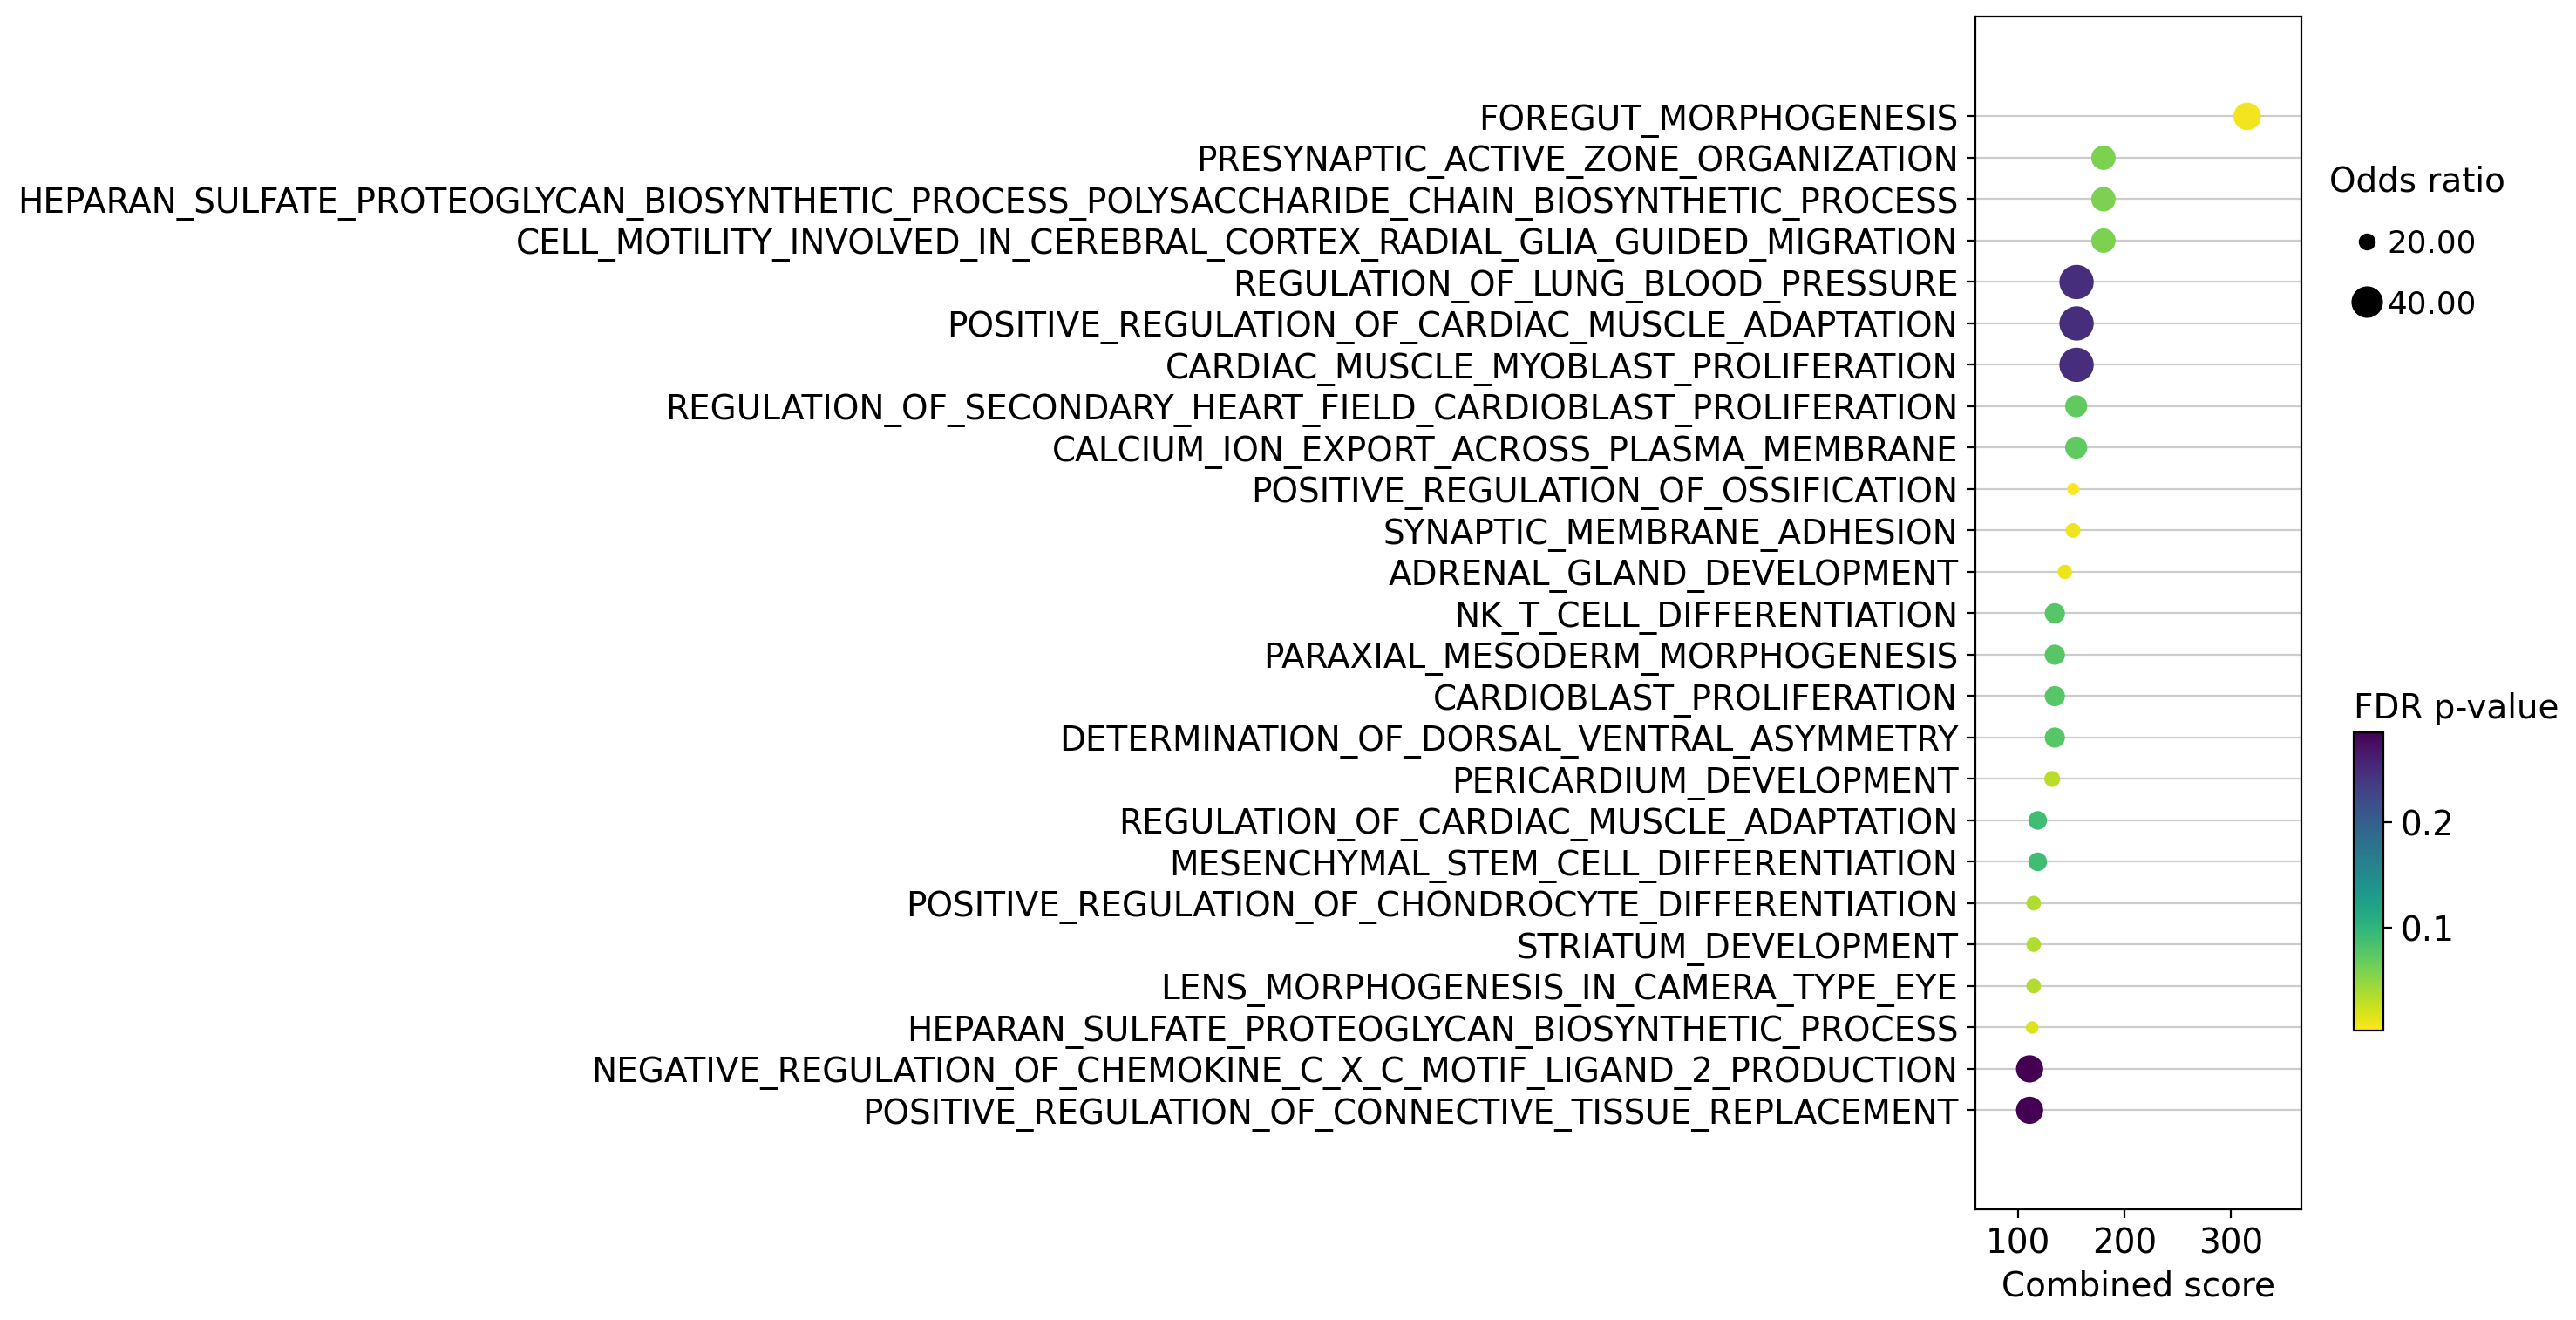

In [135]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(25),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.05,
    figsize=(3, 9)
)

We can also plot the running score for a given gene set:

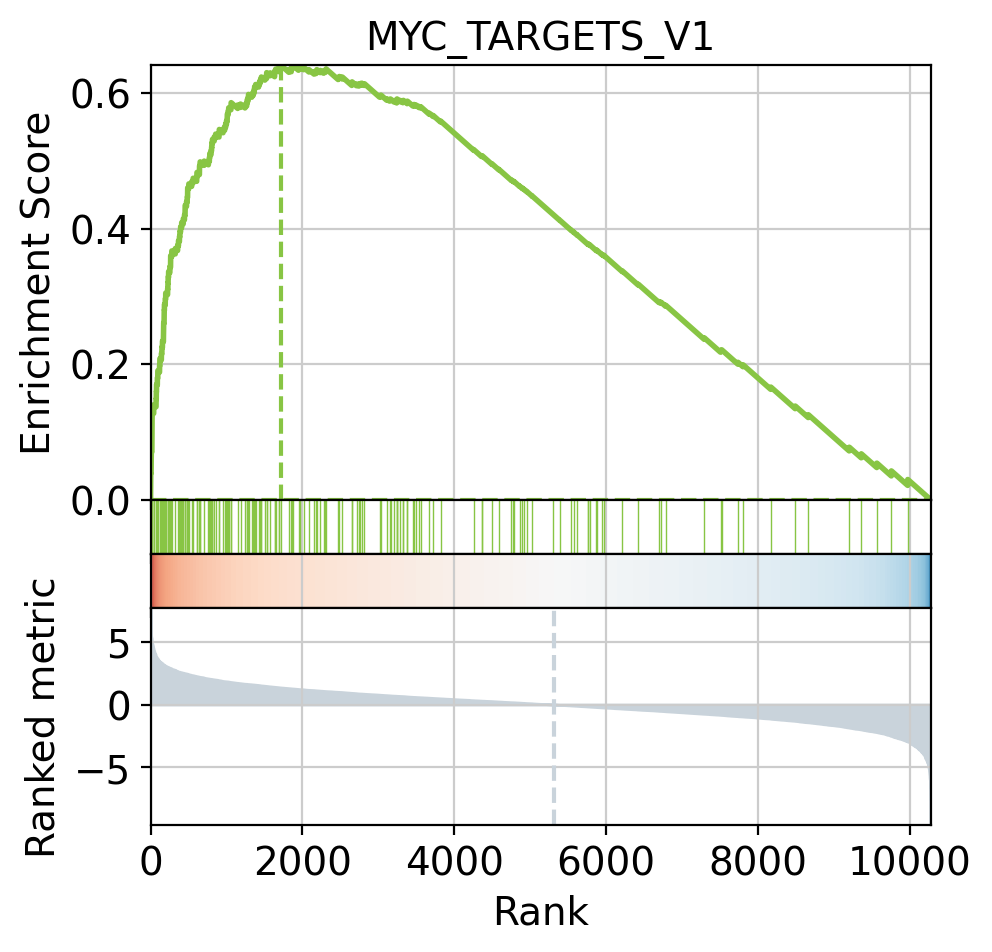

In [38]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)